In [3]:
import math
import numpy as np
from tqdm import tqdm

In [ ]:
#warning settings
np.seterr(all="ignore") #ignore np warnings, the output will be nan or inf and will be handled correctly in the code. (using np.errstate slows down the code)

In [115]:
# Configuration
TRAIN_TEST_RATIO=0.7
PROBLEM_NUMBER=8

### Data Loading and Data Preprocessing

In [116]:
# Load problem data with context manager protocol
with np.load(f'../data/problem_{PROBLEM_NUMBER}.npz') as problem:
    x_1 = problem['x']
    y_1 = problem['y']

# Shuffle the data
permutation = np.random.permutation(len(y_1))
x_1 = x_1[:, permutation]
y_1 = y_1[permutation]

# Determine train test split sizes
problem_len=len(y_1)
train_size=int(TRAIN_TEST_RATIO*problem_len)

# Split data
x_train = x_1[:, :train_size]
y_train = y_1[:train_size]

x_test = x_1[:, train_size:]
y_test = y_1[train_size:]


# Print dataset information
print(f"Problem number: {PROBLEM_NUMBER}, variables: {x_1.shape[0]}, train size: {train_size}, test size: {problem_len-train_size}")

print(f"Training data: x shape {x_train.shape}, y shape {y_train.shape}")
print(f"Testing data: x shape {x_test.shape}, y shape {y_test.shape}")

Problem number: 8, variables: 6, train size: 35000, test size: 15000
Training data: x shape (6, 35000), y shape (35000,)
Testing data: x shape (6, 15000), y shape (15000,)


### NumPy Unary and Binary Operations

In [117]:
unary_ops = [
    np.negative,
    np.abs,
    np.sqrt,
    np.exp,
    np.log,
    np.sin,
    np.cos,
    np.tan,
    np.arcsin,
    np.arccos,
    np.arctan,
    np.sinh,
    np.cosh,
    np.tanh,
    np.square,
    np.cbrt,
    np.reciprocal,
    np.ceil,
    np.floor
]

binary_ops = [
    np.add,
    np.subtract,
    np.multiply,
    np.divide,
    np.power,
    np.maximum,
    np.minimum,
    np.mod
]

### Symbolic Regression Class

In [118]:
from tree import Tree

class SymbolicRegression:
    """
    A class to implement symbolic regression using an evolutionary algorithm 
    with an island model approach.

    Parameters:
        - population_per_island (int): Number of individuals (trees) on each island.
        - island_num (int): Number of islands (sub-populations).
        - max_generations (int): Maximum number of generations before stopping.
        - mutation_rate (float): Mutation probability occurring in a tree.
        - elitism_size (int): Number of top individuals directly inserted in the next generation.
        - grow_full_ratio (float): Ratio of trees initialized with grow method vs. full method.
        - max_mutations (int): Maximum number of mutations an individual can be subjected.
        - migration_rate (float): Probability of a migration event between islands.
        - collapse_rate (float): Probability of population collapse to introduce diversity.

    Attributes:
        - unary_ops (list): List of unary operations.
        - binary_ops (list): List of binary operations.
        - best_fitness_history (list): List that stores the best fitness for each generation.
        - population (list of np.array): List of sub-populations (islands).

    Returns:

    """
    def __init__(self, population_per_island, island_num, max_generations, mutation_rate, elitism_size, grow_full_ratio, max_mutations, migration_rate, collapse_rate):
        self.population_per_island = population_per_island
        self.island_num = island_num
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.elitism_size = elitism_size
        self.grow_full_ratio = grow_full_ratio
        self.max_mutations = max_mutations
        self.migration_rate = migration_rate
        self.collapse_rate=collapse_rate

        self.unary_ops = unary_ops
        self.binary_ops = binary_ops
        self.best_fitness_history = []
        self.population = [None] * island_num

        for j in range(island_num):
            self.population[j] = np.array([
                Tree("grow") if i < int(population_per_island * self.grow_full_ratio) else Tree("full") for i in range(population_per_island)
            ])
            Tree.create_tree_from_np_formula

    # Parents selection methods
    def select_parents_fitness_proportional(self, n_elems=2, epsilon=1e-10, island=0):
        """
        Selects parents using fitness proportional selection method.

        This method randomly selects `n_elems` individuals based on their fitness.
        Individuals with lower fitness have an higher probability to be selected.
        This approach helps maintain diversity, but may lead to premature convergence 
        if few individuals have significantly better fitness than others.

        Parameters:
            - n_elems (int): Number of individuals to select.
            - epsilon (float): Small value to avoid division by zero.
            - island (int): Island on which the selection should be done.
        
        Returns:
            - A tuple containing the `n_elems` selected parents.
        """
        fitnesses = [tree.fitness for tree in self.population[island]]
        inverted_fitnesses = [1 / (fitness + epsilon) for fitness in fitnesses]  # avoid division by zero
        probabilities = inverted_fitnesses / sum(inverted_fitnesses)
        parent1, parent2 = np.random.choice(self.population[island], size=n_elems, p=probabilities, replace=False)
        return parent1, parent2
    
    
    def select_parents_rank_based(self, n_elems=2, island=0, exponential=False):
        """
        Selects parents using rank based selection method.

        Assigns probabilities based on inversed ranks instead of absolute fitness values.
        Parameters:
            - n_elems (int): Number of individuals to select.
            - island (int): Island on which the selection should be done.
            - exponential (bool): If True, the ranks are raised to the power of the exponential parameter.
        
        Returns:
            - A tuple containing the `n_elems` selected parents.
        """
        fitnesses = np.array([tree.fitness for tree in self.population[island]])
        ranks = np.argsort(fitnesses)
        if exponential:
            ranks = ranks**exponential
        inversed_ranks = len(fitnesses) - ranks
        probabilities = inversed_ranks / np.sum(inversed_ranks)
        return np.random.choice(self.population[island], n_elems, p=probabilities, replace=False)
    
    
    def select_parents_tournament(self, island=0):
        """
        Selects parents using tournament selection method.

        This method randomly selects a subset (tournament) of the population and selects the two 
        individuals with the best fitness from the subset as parents.

        Parameters:
            - island (int): Island on which the selection should be done.
        
        Returns:
            - A tuple containing the two selected parents.
        """
        tournament_size = 5
        tournament = list(np.random.choice(self.population[island], tournament_size, replace=True))
        tournament.sort(key=lambda x: x.fitness)
        return tournament[0], tournament[1]
    
    # Choose the parents selection method
    def select_parents(self, island, method="rank"):
        """
        Select parents based on the specified method.

        Parameters:
            - island (int): Island on which the selection should be done.
            - method (str): The parent selection method to use.

        Returns:
            - A tuple containing the two selected parents.
        """
        if method == "rank":
            return self.select_parents_rank_based(island=island)
        elif method == "fitness_proportional":
            return self.select_parents_fitness_proportional(island=island)
        elif method == "tournament":
            return self.select_parents_tournament(island=island)
        else:
            return self.select_parents_rank_based(island=island)
            
            
    # Mutation methods
    def mutate(self, tree):
        if np.random.rand() < 0.5:
            tree.mutate_subtree()
        else:
            mutations = np.random.randint(1, self.max_mutations+1)
            tree.mutate_single_node(num_mutations=mutations)
        
       


    # Offsprings generation via mutation and crossover
    def offspring_generation(self,island):
        new_population = np.array([])

        # Elitism   
        elite_individuals = self.population[island][:self.elitism_size]
        new_population = elite_individuals

        # Main loop
        while len(new_population) < self.population_per_island//2: 
            parent1, parent2 = self.select_parents(island=island)
            # generate offsprings (one in mutation, two in crossover)
            offsprings = np.array([])

            if(np.random.rand() < self.mutation_rate):
                parent_clone = parent1.copy_tree()
                self.mutate(parent_clone)
              
                parent_clone.compute_fitness()
                #if the fitness is valid 
                if(parent_clone.fitness is not np.inf and parent_clone.fitness is not np.nan):
                    #to not re-add the same tree if the mutation was not possible (e.g. the tree is already a leaf and other edge cases)
                    if( parent_clone.fitness!=parent1.fitness):
                        offsprings = np.append(offsprings, [parent_clone])

            else:    
                offspring1, offspring2 = parent1.crossover(parent2)
                if(offspring1 is not None and offspring2 is not None):
               
                    offspring1.compute_fitness()
                    offspring2.compute_fitness()

                    offsprings = np.append(offsprings, [offspring1, offspring2])

            # Collapse branch
            for offsp in offsprings:
                if(np.random.rand() < self.collapse_rate):
                    #clone the tree and collapse the branch
                    tree_clone = offsp.copy_tree()
                
                    Tree.collapse_branch(tree_clone.root,force_collapse=True)
                    tree_clone.compute_fitness()
                    #if the fitness is not nan or inf after collapsing
                    if(tree_clone.fitness is not None or tree_clone.fitness is not np.inf and tree_clone.fitness is not np.nan):
                            offsp = tree_clone

            new_population = np.concatenate((new_population, offsprings))
                
        return new_population
    
    # Genetic Algorithm: Evolutionary Process
    def evolve(self, verbose=False, use_std_operators=False):
        best_tree_island = np.full(self.island_num, None, dtype=object)
        best_fitness_island = np.full(self.island_num, np.inf)
        global_best_fitness = np.inf
        global_best_tree = None
        take_over = np.full(self.island_num, False)
        # self.population_per_island.sort(key=lambda x: x.fitness) 
        #numpy sort of population over fitness
        for i in range(self.island_num):
            self.population[i].sort()
      


        for generation in tqdm(range(self.max_generations)):
           
            for i in range(self.island_num):
                if take_over[i]:
                    
                    self.population[i] = np.unique(self.population[i])
                    new_trees = np.array([Tree("grow") for _ in range(self.population_per_island-len(self.population[i]))])
                 
                    self.population[i] = np.concatenate((self.population[i],new_trees))
                    self.population[i].sort()
                

                if np.random.rand() < self.migration_rate and self.island_num>1:
                    # pick a random island to migrate to (different from the current)
                    island_to_migrate = np.random.randint(0, self.island_num)
                    while i == island_to_migrate:
                        island_to_migrate = np.random.randint(0,self.island_num)
                    # select a random number from 0 to the population size of the current island
                    random_index = np.random.randint(0,len(self.population[i]))
                    
                    self.population[island_to_migrate]=np.append(self.population[island_to_migrate],self.population[i][random_index])
                    #remove the tree from the current island
                    self.population[i]=np.delete(self.population[i],random_index)

                    if(verbose):
                        print(f"Migration at {generation} gen from {i} to {island_to_migrate}")


                new_population=self.offspring_generation(island=i)
                    
                self.population[i]=np.concatenate((self.population[i],new_population))
                self.population[i].sort()
                
                generation_best_fitness_island = self.population[i][0].fitness

                if generation_best_fitness_island < best_fitness_island[i]:
                    best_fitness_island[i] = generation_best_fitness_island
                    best_tree_island[i] = self.population[i][0]
                    

                    if(best_fitness_island[i] < global_best_fitness):
                        global_best_fitness = best_fitness_island[i]
                        global_best_tree = best_tree_island[i]
                        self.best_fitness_history.append((best_fitness_island[i], generation))


                #trim the population to the best island_population
                self.population[i] = self.population[i][:self.population_per_island]

                
                
                n_best = [elem for elem in self.population[i] if elem.fitness == self.population[i][0].fitness]
                take_over[i] = False
                if len(n_best) > 0.5 * self.population_per_island:
                        take_over[i] = True
                             
                if(generation%100==0 and verbose):
                        print(f"Generation {generation + 1}, Island: {i}, Best Fitness: {best_fitness_island[i]}, Best Formula: {best_tree_island[i].to_np_formula(use_std_operators=use_std_operators)}")
            
                if global_best_fitness <= 1e-33:
                    break   

            if(generation%100==0 and not verbose):
                print(f"Generation {generation + 1}, Best Fitness: {global_best_fitness}, Best Formula: {global_best_tree.to_np_formula(use_std_operators=use_std_operators)}")

        return global_best_tree, global_best_fitness

### Problem Definition and Symbolic Regression Initialization

In [119]:
# --ISLAND SETTINGS--
ISLAND_POPULATION = 70
ISLAND_NUM = 4
MIGRATION_RATE = 0.0005


# --TREE SETTINGS--
TREE_MAX_DEPTH = 5
TREE_SPAWN_DEPTH = 3 #the max depth at which the tree will be spawned, they can grow up to TREE_MAX_DEPTH



# --GENETIC ALGORITHM SETTINGS--
MAX_GENERATIONS = 5_000
ELITISM_SIZE = 1
VAR_NUM = x_train.shape[0]
CONST_RANGE = 10 # Constats will be in the range [-CONST_RANGE, CONST_RANGE]
MAX_MUTATIONS = 3  # Maximum number of mutations in a single mutation operation
MUTATION_RATE = 0.35
GROW_FULL_RATIO = 0.95
COLLAPSE_RATE = 0.3

# --DEPTH CHECK--
min_depth_data = math.ceil(math.log(x_train.shape[0],2))
if(TREE_SPAWN_DEPTH<min_depth_data):
    TREE_SPAWN_DEPTH = min_depth_data
    print(f"Spawn depth too low, set to {TREE_SPAWN_DEPTH}")

if(TREE_MAX_DEPTH<TREE_SPAWN_DEPTH):
    TREE_MAX_DEPTH = TREE_SPAWN_DEPTH+1
    print(f"Max depth too low, set to {TREE_MAX_DEPTH}")


Tree.set_params(unary_ops, binary_ops, VAR_NUM, CONST_RANGE,TREE_MAX_DEPTH,TREE_SPAWN_DEPTH, x_train, y_train, x_test, y_test)
regressor = SymbolicRegression(
    ISLAND_POPULATION,
    ISLAND_NUM,
    MAX_GENERATIONS,
    MUTATION_RATE,
    ELITISM_SIZE,
    GROW_FULL_RATIO,
    MAX_MUTATIONS,
    MIGRATION_RATE,
    COLLAPSE_RATE
    
)
#print the trees


### Algorithm Execution and Results Computation

In [120]:

# Execute the algorithm
best_tree, best_fitness = regressor.evolve(use_std_operators=False,verbose=True)   #use_std_operators=True to use standard operators (+,-,*,/), use verbose=True to print the best tree for each island every 50 iterations

print(f"\nTrain Fitness: {best_fitness}")
# Calculate the fitness on original data
best_tree.compute_fitness(test="test")

print(f"Test Fitness: {best_tree.fitness}")
print(f"Train-Test Discrepancy: {best_fitness-best_tree.fitness}")
best_tree.compute_fitness(test="all")
print(f"Global Fitness: {best_tree.fitness}")


#Print the best tree
print(f"Best Fitness History: {[tup[0] for tup in regressor.best_fitness_history]}, changed {len(regressor.best_fitness_history)} times\n")

print(f"Best Formula: {best_tree.to_np_formula(use_std_operators=False)}\n")
print(f"Best Formula with standard operators: {best_tree.to_np_formula(use_std_operators=True)}")

  0%|          | 0/5000 [00:00<?, ?it/s]

Generation 1, Island: 0, Best Fitness: 22906126.79421837, Best Formula: np.subtract(np.subtract(np.multiply(x[5], 9.123160978525494), np.minimum(x[1], -9.6485982202695)), np.add(np.multiply(x[4], x[0]), np.add(x[2], x[3])))
Generation 1, Island: 1, Best Fitness: 22716342.31675226, Best Formula: np.subtract(np.divide(np.add(x[3], x[5]), np.power(2.8404481662318464, x[1])), np.maximum(np.maximum(x[0], -0.601113132315259), np.subtract(x[2], x[4])))
Generation 1, Island: 2, Best Fitness: 23075083.530860525, Best Formula: np.maximum(np.multiply(np.add(8.600215490603652, x[4]), np.minimum(x[5], x[1])), np.remainder(np.remainder(x[0], x[2]), x[3]))


  0%|          | 1/5000 [00:01<1:56:53,  1.40s/it]

Generation 1, Island: 3, Best Fitness: 23005519.15968219, Best Formula: np.maximum(np.multiply(np.subtract(9.94570973608953, x[0]), np.subtract(x[5], x[4])), np.minimum(x[1], np.remainder(x[3], x[2])))


  2%|▏         | 100/5000 [01:49<1:31:44,  1.12s/it]

Generation 101, Island: 0, Best Fitness: 8832981.033188974, Best Formula: np.subtract(np.subtract(np.multiply(np.multiply(np.square(9.950069719564713), x[5]), 9.950069719564713), np.maximum(x[1], np.maximum(6.571991723791882, np.square(9.950069719564713)))), np.add(np.add(x[4], x[0]), np.subtract(np.multiply(np.maximum(x[2], 9.950069719564713), np.square(6.571991723791882)), np.add(np.multiply(x[3], 9.26726475564596), np.multiply(x[3], 9.950069719564713)))))
Generation 101, Island: 1, Best Fitness: 12042260.00308125, Best Formula: np.subtract(np.divide(np.add(np.add(np.sin(x[3]), np.minimum(-4.612954721740692, 3.1769764073873006)), x[5]), np.power(4.442396594111052, np.maximum(np.minimum(x[5], x[1]), np.minimum(-9.249499532401611, 2.581340165723585)))), np.minimum(x[2], np.multiply(np.add(np.subtract(7.600677014090756, -9.249499532401611), np.remainder(-0.3783067022791169, x[0])), np.divide(np.add(7.600677014090756, x[4]), np.remainder(4.442396594111052, -4.612954721740692)))))
Generat

  2%|▏         | 101/5000 [01:50<1:26:58,  1.07s/it]

Generation 101, Island: 3, Best Fitness: 9640275.983578486, Best Formula: np.add(np.multiply(np.subtract(np.power(np.square(9.94570973608953), np.arctan(9.94570973608953)), x[0]), np.subtract(x[5], np.absolute(np.arctan(x[4])))), np.minimum(np.cosh(np.multiply(np.square(9.94570973608953), x[1])), np.add(np.subtract(x[3], -5.916353543925417), np.maximum(np.subtract(x[2], -2.3226291169000923), np.square(9.94570973608953)))))


  4%|▍         | 200/5000 [03:54<1:41:08,  1.26s/it]

Generation 201, Island: 0, Best Fitness: 7763758.28269798, Best Formula: np.subtract(np.subtract(np.multiply(np.multiply(np.square(9.26726475564596), x[5]), np.multiply(9.950069719564713, 1.5946232952435686)), np.maximum(x[1], np.maximum(6.571991723791882, np.square(9.26726475564596)))), np.add(np.maximum(x[4], x[0]), np.subtract(np.multiply(np.maximum(x[2], 9.950069719564713), np.square(6.571991723791882)), np.add(np.multiply(x[3], 9.950069719564713), np.multiply(x[3], 9.950069719564713)))))
Generation 201, Island: 1, Best Fitness: 11564587.94283177, Best Formula: np.subtract(np.divide(np.add(np.add(np.remainder(x[3], 1.0480918100503462), np.maximum(-4.612954721740692, -8.39940888067738)), x[5]), np.power(4.737446498676288, np.maximum(np.minimum(x[5], x[1]), np.add(4.442396594111052, -9.249499532401611)))), np.minimum(x[2], np.multiply(np.subtract(np.subtract(7.600677014090756, -9.249499532401611), x[0]), np.divide(np.maximum(7.600677014090756, x[4]), np.remainder(4.442396594111052, -

  4%|▍         | 201/5000 [03:55<1:41:34,  1.27s/it]

Generation 201, Island: 3, Best Fitness: 7827755.251145104, Best Formula: np.add(np.multiply(np.subtract(np.power(np.cosh(5.495799538878401), np.arctan(9.94570973608953)), np.divide(np.cosh(5.495799538878401), np.minimum(-2.017091427967812, x[0]))), np.subtract(x[5], np.absolute(np.arctan(x[4])))), np.minimum(np.cosh(np.add(np.sinh(6.777229604796883), x[1])), np.add(np.subtract(x[3], np.arctan(-2.017091427967812)), np.maximum(np.subtract(x[2], 9.94570973608953), np.sinh(6.777229604796883)))))


  6%|▌         | 300/5000 [06:04<2:04:09,  1.59s/it]

Generation 301, Island: 0, Best Fitness: 7685041.304323062, Best Formula: np.subtract(np.subtract(np.multiply(np.multiply(np.square(9.26726475564596), x[5]), np.multiply(9.950069719564713, 1.5946232952435686)), np.maximum(x[1], np.square(9.26726475564596))), np.add(np.remainder(np.add(np.minimum(9.950069719564713, x[0]), -9.10245522288591), np.multiply(x[4], np.exp(5.170725899539889))), np.subtract(np.multiply(np.maximum(x[2], 5.170725899539889), np.square(6.571991723791882)), np.add(np.multiply(x[3], 9.950069719564713), np.multiply(x[3], 9.950069719564713)))))
Generation 301, Island: 1, Best Fitness: 11072812.326964825, Best Formula: np.subtract(np.divide(np.add(np.add(np.remainder(x[3], 1.0480918100503462), np.maximum(-2.5374377384015556, -4.402990796404909)), x[5]), np.power(4.737446498676288, np.maximum(np.minimum(x[5], x[1]), -8.029182510647153))), np.minimum(x[2], np.multiply(np.subtract(np.subtract(4.737446498676288, -9.249499532401611), np.remainder(x[5], x[0])), np.divide(np.m

  6%|▌         | 301/5000 [06:05<1:53:36,  1.45s/it]

Generation 301, Island: 3, Best Fitness: 7644378.151274468, Best Formula: np.add(np.multiply(np.subtract(np.power(np.cosh(5.495799538878401), np.arctan(9.94570973608953)), np.divide(np.exp(5.495799538878401), np.minimum(-2.017091427967812, x[0]))), np.subtract(x[5], np.absolute(np.arctan(x[4])))), np.minimum(np.sinh(np.add(np.sinh(5.495799538878401), x[1])), np.add(np.maximum(np.power(2.2287744084477303, x[3]), np.exp(5.495799538878401)), np.maximum(np.subtract(x[2], 5.905743762091545), np.sinh(7.074396430313556)))))


  8%|▊         | 400/5000 [08:46<1:58:05,  1.54s/it]

Generation 401, Island: 0, Best Fitness: 7682198.405437115, Best Formula: np.subtract(np.subtract(np.multiply(np.multiply(np.square(-9.182709865296664), x[5]), np.multiply(9.950069719564713, 1.5946232952435686)), np.maximum(x[1], np.square(-9.10245522288591))), np.add(np.remainder(np.add(np.minimum(9.950069719564713, x[0]), -6.778197737324476), np.multiply(x[4], np.exp(5.170725899539889))), np.subtract(np.multiply(np.maximum(x[2], 5.170725899539889), np.square(6.571991723791882)), np.add(np.multiply(x[3], 9.950069719564713), np.multiply(x[3], 9.950069719564713)))))
Generation 401, Island: 1, Best Fitness: 7759400.24436624, Best Formula: np.add(np.divide(np.maximum(np.add(np.remainder(x[3], -3.78571284207567), np.remainder(4.442396594111052, -9.773022535948414)), x[5]), np.power(4.737446498676288, np.minimum(np.sin(x[1]), -4.612954721740692))), np.minimum(x[2], np.multiply(np.minimum(np.cosh(7.680255103938627), np.maximum(x[0], 4.737446498676288)), np.divide(np.multiply(9.78925877620758

  8%|▊         | 401/5000 [08:47<1:52:23,  1.47s/it]

Generation 401, Island: 3, Best Fitness: 7616296.702379648, Best Formula: np.add(np.multiply(np.subtract(np.power(np.cosh(5.495799538878401), np.arctan(9.94570973608953)), np.divide(np.exp(5.905743762091545), np.minimum(-2.017091427967812, x[0]))), np.subtract(x[5], np.absolute(np.arctan(x[4])))), np.minimum(np.sinh(np.add(np.sinh(5.495799538878401), x[1])), np.add(np.maximum(np.power(2.2287744084477303, x[3]), np.exp(5.495799538878401)), np.maximum(np.subtract(x[2], 5.905743762091545), np.sinh(7.074396430313556)))))


 10%|█         | 500/5000 [11:25<1:51:59,  1.49s/it]

Generation 501, Island: 0, Best Fitness: 7526177.066186546, Best Formula: np.subtract(np.subtract(np.multiply(np.multiply(np.square(-9.182709865296664), x[5]), np.multiply(9.950069719564713, 1.5946232952435686)), np.maximum(x[1], np.square(-9.10245522288591))), np.maximum(np.add(np.add(np.multiply(x[0], 9.950069719564713), -6.778197737324476), np.multiply(np.absolute(x[4]), np.exp(5.170725899539889))), np.subtract(np.multiply(np.sinh(x[2]), np.remainder(-9.10245522288591, -5.538909269050551)), np.add(np.multiply(x[3], 9.950069719564713), np.square(-6.778197737324476)))))
Generation 501, Island: 1, Best Fitness: 7352384.386102948, Best Formula: np.add(np.divide(np.maximum(np.add(np.remainder(x[3], -6.828305151698886), np.remainder(-6.828305151698886, -9.249499532401611)), x[5]), np.power(4.737446498676288, np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.add(np.add(-9.249499532401611, -9.249499532401611), np.remainder(9.789258776207582, 5.580923980764208)), np.minimum(np

 10%|█         | 501/5000 [11:27<1:55:02,  1.53s/it]

Generation 501, Island: 3, Best Fitness: 7533220.34469434, Best Formula: np.add(np.multiply(np.subtract(np.power(np.cosh(5.495799538878401), np.arctan(9.94570973608953)), np.divide(np.exp(5.905743762091545), np.minimum(-2.017091427967812, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.760426573179142), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.add(np.exp(6.7869381618495765), x[1])), np.add(np.maximum(np.power(2.2287744084477303, x[3]), np.exp(6.7869381618495765)), np.remainder(np.subtract(x[2], 5.495799538878401), np.multiply(5.495799538878401, 7.841703332813786)))))


 10%|█         | 512/5000 [11:46<2:06:12,  1.69s/it]

Migration at 512 gen from 2 to 0


 12%|█▏        | 600/5000 [14:21<2:09:44,  1.77s/it]

Generation 601, Island: 0, Best Fitness: 7526166.045113139, Best Formula: np.subtract(np.subtract(np.multiply(np.multiply(np.square(-9.182709865296664), x[5]), np.multiply(9.950069719564713, 1.5946232952435686)), np.maximum(x[1], np.square(-9.182709865296664))), np.maximum(np.add(np.add(np.multiply(x[0], 9.68138678726206), -9.182709865296664), np.multiply(np.absolute(x[4]), np.exp(5.170725899539889))), np.subtract(np.multiply(np.sinh(x[2]), np.remainder(1.5946232952435686, -5.538909269050551)), np.add(np.multiply(x[3], 9.950069719564713), np.square(7.5198159795858786)))))
Generation 601, Island: 1, Best Fitness: 7289195.741010537, Best Formula: np.add(np.divide(np.maximum(np.add(np.remainder(x[3], -6.828305151698886), np.remainder(-6.828305151698886, -9.249499532401611)), x[5]), np.power(4.737446498676288, np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.add(np.multiply(4.737446498676288, 4.140591763385748), np.maximum(-3.186632316055677, -7.929425183203529)), np.multip

 12%|█▏        | 601/5000 [14:24<2:36:26,  2.13s/it]

Generation 601, Island: 3, Best Fitness: 7530398.677532845, Best Formula: np.add(np.multiply(np.subtract(np.power(np.cosh(5.495799538878401), np.arctan(9.94570973608953)), np.divide(np.exp(5.966761174595266), np.minimum(-2.346319179605003, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.760426573179142), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.add(np.multiply(5.495799538878401, 9.94570973608953), x[1])), np.add(np.maximum(np.power(2.2287744084477303, x[3]), np.exp(6.7869381618495765)), np.remainder(np.cos(x[2]), np.multiply(6.7869381618495765, 5.495799538878401)))))


 14%|█▍        | 700/5000 [17:21<1:43:23,  1.44s/it]

Generation 701, Island: 0, Best Fitness: 7525686.670569468, Best Formula: np.subtract(np.subtract(np.multiply(np.multiply(np.square(-9.182709865296664), x[5]), np.multiply(9.950069719564713, 1.5946232952435686)), np.multiply(np.multiply(np.add(-6.544456509802769, x[1]), np.remainder(-9.182709865296664, 7.67534252906092)), np.minimum(np.square(-9.182709865296664), np.divide(-4.985330429773054, 3.2128427074711485)))), np.maximum(np.add(np.add(np.multiply(x[0], 9.57100492160134), 9.68138678726206), np.multiply(np.absolute(x[4]), np.exp(5.170725899539889))), np.subtract(np.multiply(np.sinh(x[2]), np.remainder(7.5198159795858786, -5.918721212849816)), np.add(np.power(7.67534252906092, x[3]), np.square(5.170725899539889)))))
Generation 701, Island: 1, Best Fitness: 7284013.727932745, Best Formula: np.add(np.divide(np.maximum(np.add(np.remainder(x[3], -6.828305151698886), np.remainder(0.3115370020286523, -9.249499532401611)), x[5]), np.power(4.737446498676288, np.minimum(np.sin(x[1]), -4.6129

 14%|█▍        | 701/5000 [17:22<1:47:01,  1.49s/it]

Generation 701, Island: 3, Best Fitness: 7529108.855118803, Best Formula: np.add(np.multiply(np.subtract(np.power(np.cosh(5.495799538878401), np.arctan(9.94570973608953)), np.divide(np.exp(5.966761174595266), np.minimum(-2.346319179605003, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.760426573179142), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.add(np.multiply(6.7869381618495765, 5.966761174595266), x[1])), np.add(np.maximum(np.power(4.49883871592098, x[3]), np.exp(6.7869381618495765)), np.remainder(np.cos(x[2]), np.multiply(7.966497216014478, -4.52573427091012)))))


 16%|█▌        | 800/5000 [19:51<1:39:46,  1.43s/it]

Generation 801, Island: 0, Best Fitness: 7327837.11423252, Best Formula: np.subtract(np.subtract(np.multiply(np.multiply(np.square(-9.182709865296664), x[5]), np.multiply(9.950069719564713, 1.5946232952435686)), np.multiply(np.multiply(np.add(-9.182709865296664, x[1]), np.minimum(-9.182709865296664, 1.2164979354557044)), np.minimum(np.square(1.5946232952435686), np.maximum(-3.348419973012451, x[5])))), np.maximum(np.add(np.add(np.multiply(x[0], 5.559382840816003), np.multiply(-9.182709865296664, x[5])), np.multiply(np.absolute(x[4]), np.exp(5.559382840816003))), np.subtract(np.multiply(np.sinh(x[2]), np.remainder(-9.182709865296664, -4.985330429773054)), np.maximum(np.power(7.650919832522863, x[3]), np.divide(5.559382840816003, 3.2128427074711485)))))
Generation 801, Island: 1, Best Fitness: 7280307.117969756, Best Formula: np.add(np.divide(np.maximum(np.add(np.remainder(x[3], -6.828305151698886), np.remainder(0.3115370020286523, -6.5281887419787665)), x[5]), np.power(4.737446498676288

 16%|█▌        | 801/5000 [19:53<1:41:42,  1.45s/it]

Generation 801, Island: 3, Best Fitness: 7528701.704703812, Best Formula: np.add(np.multiply(np.subtract(np.power(np.cosh(5.495799538878401), np.arctan(9.94570973608953)), np.divide(np.exp(5.966761174595266), np.minimum(-2.346319179605003, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.760426573179142), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.add(np.multiply(8.148926389812242, 9.94570973608953), x[1])), np.add(np.maximum(np.power(4.49883871592098, x[3]), np.exp(6.826083506802313)), np.remainder(np.cos(x[2]), np.multiply(9.431603311758913, -7.760426573179142)))))


 18%|█▊        | 900/5000 [22:31<1:50:30,  1.62s/it]

Generation 901, Island: 0, Best Fitness: 5448696.891782851, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(9.950069719564713), x[5]), np.multiply(9.950069719564713, 1.5946232952435686)), np.multiply(np.multiply(np.add(-9.367156144149682, x[1]), np.multiply(-9.182709865296664, 1.5946232952435686)), np.power(np.square(1.5946232952435686), np.maximum(-3.348419973012451, x[5])))), np.maximum(np.add(np.add(np.subtract(-7.235270597170025, x[0]), np.multiply(-9.367156144149682, 9.950069719564713)), np.multiply(np.cosh(x[4]), np.multiply(9.950069719564713, 1.7779586216426644))), np.subtract(np.multiply(np.maximum(x[2], 1.5946232952435686), np.divide(-5.918721212849816, 3.2128427074711485)), np.maximum(np.power(9.950069719564713, x[3]), np.multiply(9.950069719564713, 9.842993552738772)))))
Generation 901, Island: 1, Best Fitness: 7279859.887570468, Best Formula: np.add(np.divide(np.maximum(np.add(np.remainder(x[3], 0.3115370020286523), np.remainder(0.3115370020286523, -6

 18%|█▊        | 901/5000 [22:32<1:49:56,  1.61s/it]

Generation 901, Island: 3, Best Fitness: 7528700.074046578, Best Formula: np.add(np.multiply(np.subtract(np.power(np.cosh(5.495799538878401), np.arctan(9.94570973608953)), np.divide(np.exp(5.966761174595266), np.minimum(-2.346319179605003, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.760426573179142), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.add(np.multiply(8.148926389812242, 9.94570973608953), x[1])), np.add(np.maximum(np.power(4.49883871592098, x[3]), np.exp(6.826083506802313)), np.remainder(np.cos(x[2]), np.multiply(9.764646675140238, -7.304988089948273)))))


 18%|█▊        | 910/5000 [22:48<2:05:47,  1.85s/it]

Migration at 910 gen from 2 to 0


 20%|██        | 1000/5000 [25:15<1:45:22,  1.58s/it]

Generation 1001, Island: 0, Best Fitness: 5431458.792516758, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(9.950069719564713), x[5]), np.multiply(9.950069719564713, 1.5946232952435686)), np.multiply(np.multiply(np.subtract(-9.367156144149682, x[1]), np.multiply(-9.182709865296664, 1.5946232952435686)), np.power(np.square(1.5946232952435686), np.maximum(-3.348419973012451, x[5])))), np.maximum(np.add(np.add(np.subtract(-9.504410314792576, x[0]), np.multiply(-9.367156144149682, 9.950069719564713)), np.multiply(np.cosh(x[4]), np.multiply(-6.1768805346646545, -3.2683385414970427))), np.subtract(np.multiply(np.maximum(x[2], 1.5946232952435686), np.divide(-9.367156144149682, 9.842993552738772)), np.maximum(np.power(9.950069719564713, x[3]), np.multiply(9.950069719564713, 9.950069719564713)))))
Generation 1001, Island: 1, Best Fitness: 7279859.462224024, Best Formula: np.add(np.divide(np.maximum(np.add(-4.612954721740692, np.remainder(8.594735287096306, -4.61295472174

 20%|██        | 1001/5000 [25:17<1:44:50,  1.57s/it]

Generation 1001, Island: 3, Best Fitness: 7527523.613756696, Best Formula: np.add(np.multiply(np.subtract(np.power(np.cosh(5.495799538878401), np.arctan(9.94570973608953)), np.divide(np.exp(5.966761174595266), np.minimum(-2.346319179605003, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.760426573179142), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.maximum(x[1], 7.614960628538583)), np.add(np.maximum(np.power(4.49883871592098, x[3]), np.exp(6.826083506802313)), np.remainder(np.cos(x[2]), np.multiply(9.764646675140238, -7.304988089948273)))))


 22%|██▏       | 1100/5000 [27:51<1:36:43,  1.49s/it]

Generation 1101, Island: 0, Best Fitness: 5426535.485181366, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(9.950069719564713), x[5]), np.multiply(9.950069719564713, 1.5946232952435686)), np.multiply(np.multiply(np.subtract(-9.504410314792576, x[1]), np.multiply(-9.182709865296664, 1.5946232952435686)), np.power(np.square(1.5946232952435686), np.maximum(-3.348419973012451, x[5])))), np.maximum(np.add(np.add(np.add(-9.504410314792576, x[0]), np.multiply(-9.504410314792576, 9.950069719564713)), np.multiply(np.cosh(x[4]), np.multiply(-6.1768805346646545, -3.2683385414970427))), np.subtract(np.multiply(np.maximum(x[2], -6.1768805346646545), np.maximum(-6.1768805346646545, x[5])), np.maximum(np.power(1.5946232952435686, x[3]), np.square(9.950069719564713)))))
Generation 1101, Island: 1, Best Fitness: 7279146.316896158, Best Formula: np.add(np.divide(np.maximum(np.add(-4.612954721740692, np.remainder(8.594735287096306, -4.612954721740692)), x[5]), np.power(4.737446498

 22%|██▏       | 1101/5000 [27:53<1:51:07,  1.71s/it]

Generation 1101, Island: 3, Best Fitness: 7524473.709356551, Best Formula: np.add(np.multiply(np.subtract(np.power(np.cosh(5.495799538878401), np.arctan(9.94570973608953)), np.divide(np.exp(5.966761174595266), np.minimum(-2.346319179605003, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.760426573179142), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.maximum(x[1], 7.614960628538583)), np.add(np.maximum(np.power(6.826083506802313, x[3]), np.exp(6.826083506802313)), np.remainder(np.cos(x[2]), np.multiply(9.94570973608953, -8.199374481699786)))))


 24%|██▍       | 1200/5000 [30:26<1:33:23,  1.47s/it]

Generation 1201, Island: 0, Best Fitness: 4946460.706850915, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(9.950069719564713), x[5]), np.multiply(9.950069719564713, 1.7002414515448052)), np.multiply(np.multiply(np.minimum(-6.1768805346646545, x[1]), np.multiply(-9.504410314792576, 1.7002414515448052)), np.power(np.square(1.5946232952435686), np.maximum(-3.348419973012451, x[5])))), np.maximum(np.add(np.add(np.add(-9.504410314792576, x[0]), np.multiply(-9.504410314792576, 9.950069719564713)), np.multiply(np.cosh(x[4]), np.multiply(9.950069719564713, 1.5946232952435686))), np.subtract(np.multiply(np.minimum(x[2], -6.1768805346646545), np.square(1.5946232952435686)), np.maximum(np.power(9.950069719564713, x[3]), np.square(9.950069719564713)))))
Generation 1201, Island: 1, Best Fitness: 270436.1028387868, Best Formula: np.add(np.divide(np.maximum(np.multiply(np.add(-4.089130996028465, -4.612954721740692), 4.140591763385748), np.divide(np.sinh(x[5]), 6.6755372519323

 24%|██▍       | 1201/5000 [30:28<1:36:16,  1.52s/it]

Generation 1201, Island: 3, Best Fitness: 7524198.43560887, Best Formula: np.add(np.multiply(np.subtract(np.power(np.cosh(5.495799538878401), np.arctan(9.94570973608953)), np.divide(np.exp(5.966761174595266), np.minimum(-2.346319179605003, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.760426573179142), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.maximum(x[1], 7.614960628538583)), np.add(np.add(np.power(6.826083506802313, x[3]), np.exp(6.826083506802313)), np.remainder(np.exp(x[2]), np.multiply(9.94570973608953, -7.760426573179142)))))


 25%|██▌       | 1261/5000 [32:07<1:43:24,  1.66s/it]

Migration at 1261 gen from 1 to 2


 26%|██▌       | 1300/5000 [33:06<1:31:02,  1.48s/it]

Generation 1301, Island: 0, Best Fitness: 4905662.18914673, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(9.950069719564713), x[5]), np.multiply(9.950069719564713, 1.7002414515448052)), np.multiply(np.multiply(np.minimum(-7.476761817373376, x[1]), np.multiply(-9.504410314792576, 1.5946232952435686)), np.power(np.square(1.5946232952435686), np.maximum(-3.348419973012451, x[5])))), np.maximum(np.add(np.add(np.add(-9.504410314792576, x[0]), np.multiply(-9.504410314792576, 9.950069719564713)), np.multiply(np.cosh(x[4]), np.multiply(9.950069719564713, 1.5946232952435686))), np.subtract(np.multiply(np.minimum(x[2], 0.9198690654902002), np.maximum(-9.504410314792576, x[5])), np.maximum(np.power(1.5946232952435686, x[3]), np.square(9.950069719564713)))))
Generation 1301, Island: 1, Best Fitness: 254058.17109008587, Best Formula: np.add(np.divide(np.maximum(np.multiply(np.add(-4.089130996028465, -4.612954721740692), 4.140591763385748), np.divide(np.sinh(x[5]), 6.5927407

 26%|██▌       | 1301/5000 [33:08<1:33:08,  1.51s/it]

Generation 1301, Island: 3, Best Fitness: 7524198.42904468, Best Formula: np.add(np.multiply(np.subtract(np.power(np.cosh(5.495799538878401), np.arctan(9.94570973608953)), np.divide(np.exp(5.966761174595266), np.minimum(-2.346319179605003, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.760426573179142), np.absolute(np.cbrt(x[4])))), np.minimum(np.cosh(np.maximum(x[1], 7.614960628538583)), np.add(np.add(np.power(6.826083506802313, x[3]), np.exp(6.826083506802313)), np.remainder(np.exp(x[2]), np.multiply(9.94570973608953, -7.760426573179142)))))


 27%|██▋       | 1360/5000 [34:41<1:48:43,  1.79s/it]

Migration at 1360 gen from 0 to 1


 28%|██▊       | 1400/5000 [35:46<1:43:39,  1.73s/it]

Generation 1401, Island: 0, Best Fitness: 4799445.131400399, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(9.950069719564713), x[5]), np.multiply(9.950069719564713, 1.7002414515448052)), np.multiply(np.multiply(np.minimum(-7.476761817373376, x[1]), np.multiply(-9.192658984697735, 1.5946232952435686)), np.power(np.cosh(1.5946232952435686), np.maximum(-3.348419973012451, x[5])))), np.add(np.add(np.add(np.add(-9.504410314792576, x[0]), np.multiply(-9.934075842351564, 9.950069719564713)), np.multiply(np.cosh(x[4]), np.multiply(9.950069719564713, 1.5946232952435686))), np.subtract(np.multiply(np.add(x[2], 1.7002414515448052), np.maximum(-3.348419973012451, x[5])), np.maximum(np.power(1.5946232952435686, x[3]), np.square(9.950069719564713)))))
Generation 1401, Island: 1, Best Fitness: 242088.58790983073, Best Formula: np.add(np.divide(np.maximum(np.multiply(np.add(-5.311400082166291, -4.612954721740692), 4.140591763385748), np.divide(np.sinh(x[5]), 6.592740756001071)

 28%|██▊       | 1401/5000 [35:48<1:40:32,  1.68s/it]

Generation 1401, Island: 3, Best Fitness: 7521974.4828226715, Best Formula: np.add(np.multiply(np.subtract(np.power(np.cosh(5.495799538878401), np.arctan(9.94570973608953)), np.divide(np.exp(6.140408532192126), np.minimum(-2.346319179605003, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.760426573179142), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.maximum(x[1], 7.614960628538583)), np.add(np.add(np.power(9.94570973608953, x[3]), np.exp(6.826083506802313)), np.remainder(np.exp(x[2]), np.multiply(5.495799538878401, -7.760426573179142)))))


 30%|███       | 1500/5000 [38:29<1:39:23,  1.70s/it]

Generation 1501, Island: 0, Best Fitness: 3942298.755279976, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(9.82853410771045), x[5]), np.multiply(9.950069719564713, np.maximum(1.5946232952435686, x[5]))), np.multiply(np.multiply(np.minimum(-7.476761817373376, x[1]), np.multiply(-9.934075842351564, 1.5946232952435686)), np.power(np.cosh(1.5946232952435686), np.maximum(-3.348419973012451, x[5])))), np.add(np.add(np.add(np.add(-9.934075842351564, x[0]), np.multiply(-9.934075842351564, 9.950069719564713)), np.multiply(np.cosh(x[4]), np.multiply(9.950069719564713, 1.7002414515448052))), np.subtract(np.multiply(np.add(x[2], 9.950069719564713), np.maximum(-3.348419973012451, x[5])), np.maximum(np.divide(1.5946232952435686, x[3]), np.square(-9.934075842351564)))))
Generation 1501, Island: 1, Best Fitness: 238889.82826984127, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), 6.592740756001071), np.divide(np.sinh(x[5]), 6.592740756001071)), np.power(4.737

 30%|███       | 1501/5000 [38:31<1:40:41,  1.73s/it]

Generation 1501, Island: 3, Best Fitness: 7521821.051076939, Best Formula: np.add(np.multiply(np.subtract(np.power(np.cosh(5.495799538878401), np.arctan(9.94570973608953)), np.divide(np.exp(6.140408532192126), np.minimum(-2.346319179605003, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.760426573179142), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.maximum(x[1], 7.614960628538583)), np.add(np.add(np.power(6.826083506802313, x[3]), np.exp(6.826083506802313)), np.remainder(np.exp(x[2]), np.multiply(4.969572681847474, -7.760426573179142)))))


 32%|███▏      | 1600/5000 [41:20<1:39:43,  1.76s/it]

Generation 1601, Island: 0, Best Fitness: 3830294.313579574, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(-9.678741404604295), x[5]), np.multiply(9.82853410771045, np.maximum(1.5946232952435686, x[5]))), np.multiply(np.multiply(np.minimum(-7.68442576051503, x[1]), np.multiply(-9.934075842351564, 1.5946232952435686)), np.power(np.cosh(1.5946232952435686), np.maximum(-3.348419973012451, x[5])))), np.add(np.add(np.minimum(np.add(-3.348419973012451, x[0]), np.tan(-1.5424019688175612)), np.multiply(np.cosh(x[4]), np.multiply(9.950069719564713, 3.0709149897767887))), np.subtract(np.multiply(np.add(x[2], 9.950069719564713), np.multiply(-6.252722121623783, 4.866877289600744)), np.maximum(np.divide(1.5946232952435686, x[3]), np.floor(9.950069719564713)))))
Generation 1601, Island: 1, Best Fitness: 224460.35888345414, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), 6.529251677494862), np.divide(np.sinh(x[5]), 6.529251677494862)), np.power(4.7374464986

 32%|███▏      | 1601/5000 [41:21<1:33:58,  1.66s/it]

Generation 1601, Island: 3, Best Fitness: 7521582.451719508, Best Formula: np.add(np.multiply(np.subtract(np.power(np.cosh(5.495799538878401), np.arctan(9.94570973608953)), np.divide(np.exp(6.140408532192126), np.minimum(-2.3542477726372617, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.760426573179142), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.maximum(x[1], 7.614960628538583)), np.add(np.add(np.power(6.826083506802313, x[3]), np.exp(6.826083506802313)), np.remainder(np.exp(x[2]), np.multiply(5.1592966476341555, -7.760426573179142)))))


 34%|███▍      | 1700/5000 [43:53<1:25:34,  1.56s/it]

Generation 1701, Island: 0, Best Fitness: 3823513.7931852057, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(-9.678741404604295), x[5]), np.multiply(9.82853410771045, np.maximum(1.5946232952435686, x[5]))), np.multiply(np.multiply(np.minimum(-7.68442576051503, x[1]), np.multiply(-9.934075842351564, 1.5946232952435686)), np.power(np.cosh(1.5946232952435686), np.maximum(-3.348419973012451, x[5])))), np.add(np.add(np.add(np.add(-9.934075842351564, x[0]), np.maximum(-1.538272446395423, x[5])), np.multiply(np.cosh(x[4]), np.multiply(9.950069719564713, 3.0709149897767887))), np.subtract(np.multiply(np.add(x[2], 9.950069719564713), np.multiply(-6.810516442729664, 4.866877289600744)), np.minimum(np.multiply(x[3], 9.950069719564713), np.square(-9.678741404604295)))))
Generation 1701, Island: 1, Best Fitness: 132508.891749628, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), 6.529251677494862), np.divide(np.sin(x[5]), 4.185891203921599)), np.power(4.737

 34%|███▍      | 1701/5000 [43:54<1:25:18,  1.55s/it]

Generation 1701, Island: 3, Best Fitness: 7515103.2070106305, Best Formula: np.add(np.multiply(np.subtract(np.power(np.cosh(5.495799538878401), np.arctan(9.94570973608953)), np.divide(np.exp(6.826083506802313), np.minimum(-5.713201595899244, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.760426573179142), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.maximum(x[1], 7.614960628538583)), np.add(np.add(np.power(7.966497216014478, x[3]), np.exp(6.826083506802313)), np.remainder(np.cos(x[2]), np.multiply(9.94570973608953, -7.760426573179142)))))


 36%|███▌      | 1800/5000 [46:30<1:16:49,  1.44s/it]

Generation 1801, Island: 0, Best Fitness: 3823513.7931852057, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(-9.678741404604295), x[5]), np.multiply(9.82853410771045, np.maximum(1.5946232952435686, x[5]))), np.multiply(np.multiply(np.minimum(-7.68442576051503, x[1]), np.multiply(-9.934075842351564, 1.5946232952435686)), np.power(np.cosh(1.5946232952435686), np.maximum(-3.348419973012451, x[5])))), np.add(np.add(np.add(np.add(-9.934075842351564, x[0]), np.maximum(-1.538272446395423, x[5])), np.multiply(np.cosh(x[4]), np.multiply(9.950069719564713, 3.0709149897767887))), np.subtract(np.multiply(np.add(x[2], 9.950069719564713), np.multiply(-6.810516442729664, 4.866877289600744)), np.minimum(np.multiply(x[3], 9.950069719564713), np.square(-9.678741404604295)))))
Generation 1801, Island: 1, Best Fitness: 120926.22790456536, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), 6.529251677494862), np.divide(np.sin(x[5]), 3.6123066987645913)), np.power(4.

 36%|███▌      | 1801/5000 [46:31<1:20:42,  1.51s/it]

Generation 1801, Island: 3, Best Fitness: 7513631.429111536, Best Formula: np.add(np.multiply(np.subtract(np.power(np.cosh(5.495799538878401), np.arctan(9.94570973608953)), np.divide(np.power(7.136989002063618, 3.4892028086726707), np.minimum(-5.713201595899244, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.760426573179142), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.maximum(x[1], 7.614960628538583)), np.add(np.add(np.power(7.614960628538583, x[3]), np.exp(6.826083506802313)), np.remainder(np.cos(x[2]), np.multiply(9.94570973608953, -8.013225553147869)))))


 38%|███▊      | 1900/5000 [49:08<1:30:09,  1.75s/it]

Generation 1901, Island: 0, Best Fitness: 3814391.8000610024, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(-9.678741404604295), x[5]), np.multiply(9.82853410771045, np.maximum(1.5946232952435686, x[5]))), np.multiply(np.multiply(np.minimum(-7.68442576051503, x[1]), np.multiply(-9.934075842351564, 1.5946232952435686)), np.power(np.cosh(1.5946232952435686), np.maximum(-3.348419973012451, x[5])))), np.add(np.remainder(np.add(np.add(-9.262686397400756, x[0]), np.maximum(-3.348419973012451, x[5])), np.multiply(np.cosh(x[4]), np.multiply(-6.51071575467514, -5.487595231656499))), np.subtract(np.multiply(np.add(x[2], 9.950069719564713), np.multiply(-6.810516442729664, 4.866877289600744)), np.minimum(np.multiply(x[3], 9.950069719564713), np.square(-9.678741404604295)))))
Generation 1901, Island: 1, Best Fitness: 116477.41123325848, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), 6.529251677494862), np.divide(np.sin(x[5]), 3.6123066987645913)), np.po

 38%|███▊      | 1901/5000 [49:10<1:26:45,  1.68s/it]

Generation 1901, Island: 3, Best Fitness: 7513511.448943414, Best Formula: np.add(np.multiply(np.subtract(np.power(np.cosh(5.495799538878401), np.arctan(9.94570973608953)), np.divide(np.power(7.136989002063618, 3.4892028086726707), np.minimum(-5.713201595899244, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.760426573179142), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.maximum(x[1], 7.614960628538583)), np.add(np.add(np.power(5.495799538878401, x[3]), np.exp(6.826083506802313)), np.remainder(np.cos(x[2]), np.multiply(9.94570973608953, -8.013225553147869)))))


 40%|████      | 2000/5000 [52:29<1:40:51,  2.02s/it]

Generation 2001, Island: 0, Best Fitness: 3578888.7692943774, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(9.950069719564713), x[5]), np.multiply(9.950069719564713, np.maximum(1.5946232952435686, x[5]))), np.multiply(np.multiply(np.minimum(-8.191444376410358, x[1]), np.subtract(-9.934075842351564, 1.5946232952435686)), np.power(np.cosh(1.6824220879299538), np.maximum(-1.538272446395423, x[5])))), np.add(np.remainder(np.divide(np.add(-9.262686397400756, x[0]), np.maximum(-3.348419973012451, x[5])), np.multiply(np.cosh(x[4]), np.multiply(-9.678741404604295, -5.487595231656499))), np.subtract(np.multiply(np.add(x[2], 9.950069719564713), np.multiply(-6.810516442729664, 4.866877289600744)), np.add(np.remainder(x[3], -8.191444376410358), np.arctan(-9.262686397400756)))))
Generation 2001, Island: 1, Best Fitness: 116416.56896451293, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), 6.529251677494862), np.divide(np.sin(x[5]), 3.6123066987645913)), np

 40%|████      | 2001/5000 [52:31<1:37:07,  1.94s/it]

Generation 2001, Island: 3, Best Fitness: 7511581.793029028, Best Formula: np.add(np.multiply(np.subtract(np.power(np.cosh(5.495799538878401), np.arctan(9.94570973608953)), np.divide(np.power(7.136989002063618, 3.4892028086726707), np.minimum(-5.713201595899244, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.760426573179142), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.maximum(x[1], 7.966497216014478)), np.add(np.add(np.power(3.4892028086726707, x[3]), np.exp(6.826083506802313)), np.remainder(np.cos(x[2]), np.multiply(9.94570973608953, -7.760426573179142)))))


 42%|████▏     | 2100/5000 [55:26<1:26:55,  1.80s/it]

Generation 2101, Island: 0, Best Fitness: 3532705.933753294, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(9.950069719564713), x[5]), np.multiply(9.950069719564713, np.maximum(1.5946232952435686, x[5]))), np.multiply(np.multiply(np.minimum(-8.191444376410358, x[1]), np.subtract(-9.262686397400756, 1.5946232952435686)), np.power(np.cosh(1.6824220879299538), np.maximum(-3.348419973012451, x[5])))), np.add(np.remainder(np.divide(np.add(x[0], -5.085946418974814), np.maximum(-3.348419973012451, x[5])), np.multiply(np.cosh(x[4]), np.multiply(-9.678741404604295, -5.487595231656499))), np.subtract(np.multiply(np.add(x[2], 9.950069719564713), np.multiply(-5.487595231656499, 4.866877289600744)), np.add(np.add(x[3], 9.950069719564713), np.square(9.950069719564713)))))
Generation 2101, Island: 1, Best Fitness: 116384.70009524959, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), 6.529251677494862), np.divide(np.sin(x[5]), 3.0989381212444673)), np.power(4.

 42%|████▏     | 2101/5000 [55:27<1:25:20,  1.77s/it]

Generation 2101, Island: 3, Best Fitness: 7511581.793029028, Best Formula: np.add(np.multiply(np.subtract(np.power(np.cosh(5.495799538878401), np.arctan(9.94570973608953)), np.divide(np.power(7.136989002063618, 3.4892028086726707), np.minimum(-5.713201595899244, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.760426573179142), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.maximum(x[1], 7.966497216014478)), np.add(np.add(np.power(3.4892028086726707, x[3]), np.exp(6.826083506802313)), np.remainder(np.cos(x[2]), np.multiply(9.94570973608953, -7.760426573179142)))))


 44%|████▍     | 2200/5000 [58:21<1:29:19,  1.91s/it]

Generation 2201, Island: 0, Best Fitness: 3523288.7343509393, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(9.950069719564713), x[5]), np.multiply(9.950069719564713, np.maximum(1.5946232952435686, x[5]))), np.multiply(np.multiply(np.minimum(-8.191444376410358, x[1]), np.subtract(-9.262686397400756, 1.5946232952435686)), np.power(np.cosh(1.6824220879299538), np.maximum(-5.085946418974814, x[5])))), np.add(np.remainder(np.divide(np.remainder(x[0], -5.487595231656499), np.maximum(-3.049072798317316, x[5])), np.multiply(np.cosh(x[4]), np.multiply(-9.678741404604295, -5.487595231656499))), np.subtract(np.multiply(np.maximum(x[2], 9.950069719564713), np.multiply(-5.487595231656499, 4.866877289600744)), np.add(np.multiply(x[3], 9.950069719564713), np.square(9.950069719564713)))))
Generation 2201, Island: 1, Best Fitness: 116180.64213409806, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), 6.529251677494862), np.divide(np.sin(x[5]), np.subtract(8.428

 44%|████▍     | 2201/5000 [58:22<1:27:13,  1.87s/it]

Generation 2201, Island: 3, Best Fitness: 7074651.730487383, Best Formula: np.add(np.multiply(np.subtract(np.power(np.sinh(5.495799538878401), np.arctan(9.94570973608953)), np.divide(np.exp(6.826083506802313), np.minimum(-5.713201595899244, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.760426573179142), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.maximum(x[1], 7.966497216014478)), np.add(np.add(np.power(3.4892028086726707, x[3]), -7.760426573179142), np.remainder(np.remainder(x[2], x[5]), np.exp(7.136989002063618)))))


 46%|████▌     | 2300/5000 [1:01:30<1:25:19,  1.90s/it]

Generation 2301, Island: 0, Best Fitness: 3314095.5861079036, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(-9.678741404604295), x[5]), np.multiply(9.950069719564713, np.maximum(1.5946232952435686, x[5]))), np.multiply(np.multiply(np.minimum(-8.191444376410358, x[1]), np.subtract(-8.191444376410358, 1.5946232952435686)), np.power(np.cosh(1.6824220879299538), np.maximum(-5.085946418974814, x[5])))), np.add(np.remainder(np.divide(np.remainder(x[0], -5.085946418974814), np.sin(x[5])), np.multiply(np.cosh(x[4]), np.multiply(-9.678741404604295, -5.487595231656499))), np.subtract(np.multiply(np.maximum(x[2], 9.950069719564713), np.multiply(-9.055999529050954, 4.866877289600744)), np.add(np.multiply(x[3], 9.950069719564713), np.cosh(1.5946232952435686)))))
Generation 2301, Island: 1, Best Fitness: 116180.64213409806, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), 6.529251677494862), np.divide(np.sin(x[5]), np.subtract(8.42826527062152, 5.274174233

 46%|████▌     | 2301/5000 [1:01:32<1:31:30,  2.03s/it]

Generation 2301, Island: 3, Best Fitness: 6338388.656492292, Best Formula: np.add(np.multiply(np.subtract(np.power(np.sinh(5.495799538878401), np.arctan(9.94570973608953)), np.divide(np.exp(7.136989002063618), np.minimum(-3.261502184322051, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.760426573179142), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.maximum(x[1], np.exp(5.495799538878401))), np.add(np.add(np.floor(x[3]), np.sinh(5.495799538878401)), np.remainder(np.remainder(x[2], x[5]), np.exp(7.6428317374757135)))))


 48%|████▊     | 2400/5000 [1:04:34<1:22:48,  1.91s/it]

Generation 2401, Island: 0, Best Fitness: 3309866.45969494, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(-9.678741404604295), x[5]), np.multiply(9.950069719564713, np.maximum(1.5946232952435686, x[5]))), np.multiply(np.multiply(np.minimum(-8.191444376410358, x[1]), np.subtract(-8.191444376410358, 1.5946232952435686)), np.power(np.cosh(1.6824220879299538), np.maximum(-8.191444376410358, x[5])))), np.add(np.remainder(np.divide(np.remainder(x[0], -3.4060787895575695), np.sin(x[5])), np.multiply(np.cosh(x[4]), np.multiply(-9.907606296966714, -5.487595231656499))), np.subtract(np.multiply(np.maximum(x[2], 9.950069719564713), np.multiply(-9.055999529050954, 4.866877289600744)), np.add(np.multiply(x[3], 9.950069719564713), 9.950069719564713))))
Generation 2401, Island: 1, Best Fitness: 116009.32134046682, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), 6.529251677494862), np.divide(np.sin(x[5]), np.subtract(8.42826527062152, 5.274174233782327))), 

 48%|████▊     | 2401/5000 [1:04:36<1:17:54,  1.80s/it]

Generation 2401, Island: 3, Best Fitness: 5818985.00420106, Best Formula: np.add(np.multiply(np.subtract(np.power(np.sinh(5.495799538878401), np.arctan(7.136989002063618)), np.divide(np.exp(7.966497216014478), np.minimum(-3.261502184322051, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.760426573179142), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.maximum(x[1], np.sinh(5.495799538878401))), np.add(np.negative(np.multiply(x[3], -7.760426573179142)), np.remainder(np.remainder(x[2], x[5]), np.exp(8.089152766454802)))))


 50%|█████     | 2500/5000 [1:07:42<1:14:11,  1.78s/it]

Generation 2501, Island: 0, Best Fitness: 2485817.3316150503, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(9.950069719564713), np.subtract(x[5], -1.1444200785880287)), np.multiply(9.950069719564713, np.negative(-2.080644542913886))), np.multiply(np.multiply(np.minimum(-8.191444376410358, x[1]), np.subtract(-8.191444376410358, 1.6824220879299538)), np.power(np.cosh(1.6824220879299538), np.maximum(-5.487595231656499, x[5])))), np.add(np.remainder(np.divide(np.remainder(x[0], -8.191444376410358), np.sin(x[5])), np.multiply(np.cosh(x[4]), np.multiply(-9.907606296966714, -5.983404993501196))), np.subtract(np.minimum(-5.542783980688997, x[2]), np.add(np.multiply(x[3], 9.950069719564713), np.multiply(-9.907606296966714, -5.983404993501196)))))
Generation 2501, Island: 1, Best Fitness: 115822.04256892926, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), 6.529251677494862), np.divide(np.sin(x[5]), np.subtract(9.909950839095384, 6.529251677494862))), 

 50%|█████     | 2501/5000 [1:07:44<1:15:48,  1.82s/it]

Generation 2501, Island: 3, Best Fitness: 5770075.816047429, Best Formula: np.add(np.multiply(np.subtract(np.power(np.sinh(5.466567958964365), np.arctan(7.966497216014478)), np.divide(np.exp(7.966497216014478), np.minimum(-3.261502184322051, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.760426573179142), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.maximum(x[1], np.sinh(8.089152766454802))), np.add(np.subtract(x[3], np.sinh(5.495799538878401)), np.remainder(np.remainder(x[2], x[5]), np.sinh(8.805087642586152)))))


 50%|█████     | 2509/5000 [1:08:01<1:26:04,  2.07s/it]

Migration at 2509 gen from 3 to 1


 52%|█████▏    | 2600/5000 [1:10:59<1:16:06,  1.90s/it]

Generation 2601, Island: 0, Best Fitness: 2409206.446658862, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(9.950069719564713), np.subtract(x[5], -1.1444200785880287)), np.multiply(np.add(9.276599012482016, 1.3275003935248044), np.negative(-2.080644542913886))), np.multiply(np.multiply(np.minimum(-8.191444376410358, x[1]), np.subtract(-8.191444376410358, 1.6824220879299538)), np.power(np.cosh(1.6824220879299538), np.maximum(-5.487595231656499, x[5])))), np.add(np.remainder(np.divide(np.minimum(x[0], -9.907606296966714), np.sin(x[5])), np.multiply(np.cosh(x[4]), np.multiply(-8.191444376410358, -5.983404993501196))), np.subtract(np.add(np.cosh(x[4]), x[2]), np.add(np.exp(x[3]), np.square(9.950069719564713)))))
Generation 2601, Island: 1, Best Fitness: 113805.00719469273, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), np.add(3.493533189186591, 2.951732035450556)), np.divide(np.sin(x[5]), 3.493533189186591)), np.power(4.737446498676288, np.minim

 52%|█████▏    | 2601/5000 [1:11:01<1:12:09,  1.80s/it]

Generation 2601, Island: 3, Best Fitness: 5765816.144046612, Best Formula: np.add(np.multiply(np.subtract(np.power(np.sinh(5.466567958964365), np.arctan(7.966497216014478)), np.divide(np.exp(7.966497216014478), np.minimum(-3.261502184322051, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.882177565702291), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.add(x[1], np.sinh(7.966497216014478))), np.add(np.remainder(np.add(x[3], 1.112364998072854), np.remainder(x[5], 8.805087642586152)), np.remainder(np.remainder(x[2], x[5]), np.sinh(8.805087642586152)))))


 54%|█████▍    | 2700/5000 [1:14:13<1:17:06,  2.01s/it]

Generation 2701, Island: 0, Best Fitness: 1167253.656954832, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(9.950069719564713), np.subtract(x[5], -2.4302099001557913)), np.multiply(np.add(9.276599012482016, 1.3275003935248044), np.cosh(-2.080644542913886))), np.multiply(np.multiply(np.minimum(-8.191444376410358, x[1]), np.subtract(-8.610408134819739, 1.6824220879299538)), np.power(np.cosh(1.6824220879299538), np.maximum(-8.610408134819739, x[5])))), np.add(np.remainder(np.divide(np.minimum(x[0], -9.907606296966714), np.sin(x[5])), np.multiply(np.cosh(x[4]), np.multiply(-8.191444376410358, -5.983404993501196))), np.subtract(np.maximum(np.cosh(x[4]), np.add(-3.195509472594164, x[2])), np.add(np.exp(x[3]), np.sin(x[5])))))
Generation 2701, Island: 1, Best Fitness: 112550.60918656878, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), np.add(3.493533189186591, 2.951732035450556)), np.divide(np.sin(x[5]), 3.5962299757001244)), np.power(4.737446498676

 54%|█████▍    | 2701/5000 [1:14:15<1:18:05,  2.04s/it]

Generation 2701, Island: 3, Best Fitness: 5733078.217096548, Best Formula: np.add(np.multiply(np.subtract(np.power(np.sinh(5.466567958964365), np.arctan(7.966497216014478)), np.divide(np.exp(7.966497216014478), np.minimum(-3.261502184322051, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.882177565702291), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.add(x[1], np.sinh(7.966497216014478))), np.add(np.multiply(np.add(x[3], 9.674295092519944), np.remainder(x[5], 9.674295092519944)), np.remainder(np.remainder(x[2], x[5]), np.sinh(8.805087642586152)))))


 56%|█████▌    | 2800/5000 [1:17:34<1:13:55,  2.02s/it]

Generation 2801, Island: 0, Best Fitness: 841447.7976979591, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(9.950069719564713), np.subtract(x[5], -2.4302099001557913)), np.multiply(np.add(9.276599012482016, 1.3275003935248044), np.cosh(-2.080644542913886))), np.multiply(np.multiply(np.minimum(-8.191444376410358, x[1]), np.subtract(-8.610408134819739, 1.6824220879299538)), np.power(np.square(1.6824220879299538), np.maximum(-8.610408134819739, x[5])))), np.add(np.remainder(np.divide(np.minimum(x[0], -9.907606296966714), np.maximum(1.3275003935248044, x[5])), np.multiply(np.cosh(x[4]), np.multiply(-5.055160884592606, -6.941662769053969))), np.maximum(np.maximum(-0.3368167024646205, np.remainder(-8.610408134819739, x[2])), np.add(np.negative(x[3]), np.square(-8.610408134819739)))))
Generation 2801, Island: 1, Best Fitness: 112550.60918656878, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), np.add(3.493533189186591, 2.951732035450556)), np.divide(

 56%|█████▌    | 2801/5000 [1:17:36<1:15:29,  2.06s/it]

Generation 2801, Island: 3, Best Fitness: 5733078.217096548, Best Formula: np.add(np.multiply(np.subtract(np.power(np.sinh(5.466567958964365), np.arctan(7.966497216014478)), np.divide(np.exp(7.966497216014478), np.minimum(-3.261502184322051, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.882177565702291), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.add(x[1], np.sinh(7.966497216014478))), np.add(np.multiply(np.add(x[3], 9.674295092519944), np.remainder(x[5], 9.674295092519944)), np.remainder(np.remainder(x[2], x[5]), np.sinh(8.805087642586152)))))


 58%|█████▊    | 2900/5000 [1:20:59<1:15:24,  2.15s/it]

Generation 2901, Island: 0, Best Fitness: 823232.7268703706, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(-9.907606296966714), np.subtract(x[5], -2.4302099001557913)), np.multiply(np.add(9.276599012482016, 1.3275003935248044), np.cosh(-2.080644542913886))), np.multiply(np.multiply(np.minimum(-8.191444376410358, x[1]), np.subtract(-8.610408134819739, 1.6824220879299538)), np.power(np.square(1.6824220879299538), np.maximum(-8.610408134819739, x[5])))), np.add(np.remainder(np.divide(np.minimum(x[0], -9.907606296966714), np.maximum(0.6059047972861009, x[5])), np.multiply(np.cosh(x[4]), np.multiply(-5.055160884592606, -6.941662769053969))), np.maximum(np.maximum(np.multiply(x[5], 9.522246145998722), np.add(-8.610408134819739, x[2])), np.multiply(np.negative(x[3]), np.multiply(-8.191444376410358, -8.191444376410358)))))
Generation 2901, Island: 1, Best Fitness: 112550.60918656878, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), np.add(3.493533189

 58%|█████▊    | 2901/5000 [1:21:02<1:23:17,  2.38s/it]

Generation 2901, Island: 3, Best Fitness: 5731388.774345817, Best Formula: np.add(np.multiply(np.subtract(np.power(np.sinh(5.466567958964365), np.arctan(7.966497216014478)), np.divide(np.exp(7.966497216014478), np.minimum(-3.261502184322051, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.882177565702291), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.add(x[1], np.sinh(7.966497216014478))), np.add(np.multiply(np.add(x[3], 9.942678375908411), np.remainder(x[5], 9.942678375908411)), np.remainder(np.remainder(x[2], x[5]), np.sinh(8.805087642586152)))))


 60%|██████    | 3000/5000 [1:24:17<1:04:09,  1.92s/it]

Generation 3001, Island: 0, Best Fitness: 810148.5076370175, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(-9.907606296966714), np.subtract(x[5], -2.4416220554731183)), np.multiply(np.add(9.276599012482016, 1.3275003935248044), np.cosh(-2.080644542913886))), np.multiply(np.multiply(np.minimum(-8.191444376410358, x[1]), np.subtract(-8.610408134819739, 1.6824220879299538)), np.power(np.square(1.6824220879299538), np.maximum(-8.610408134819739, x[5])))), np.add(np.remainder(np.divide(np.minimum(x[0], -9.907606296966714), np.maximum(0.6059047972861009, x[5])), np.multiply(np.cosh(x[4]), np.multiply(-5.055160884592606, -6.941662769053969))), np.maximum(np.subtract(np.multiply(x[5], 9.522246145998722), np.add(-9.907606296966714, x[2])), np.multiply(np.negative(x[3]), np.multiply(-8.610408134819739, -8.610408134819739)))))
Generation 3001, Island: 1, Best Fitness: 112550.60918656878, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), np.add(3.49353318

 60%|██████    | 3001/5000 [1:24:20<1:10:57,  2.13s/it]

Generation 3001, Island: 3, Best Fitness: 5731388.774345817, Best Formula: np.add(np.multiply(np.subtract(np.power(np.sinh(5.466567958964365), np.arctan(7.966497216014478)), np.divide(np.exp(7.966497216014478), np.minimum(-3.261502184322051, x[0]))), np.subtract(np.add(np.add(x[5], 7.966497216014478), -7.882177565702291), np.absolute(np.cbrt(x[4])))), np.minimum(np.sinh(np.add(x[1], np.sinh(7.966497216014478))), np.add(np.multiply(np.add(x[3], 9.942678375908411), np.remainder(x[5], 9.942678375908411)), np.remainder(np.remainder(x[2], x[5]), np.sinh(8.805087642586152)))))


 61%|██████▏   | 3070/5000 [1:26:43<1:10:04,  2.18s/it]

Migration at 3070 gen from 0 to 3


 62%|██████▏   | 3100/5000 [1:27:33<53:15,  1.68s/it]  

Generation 3101, Island: 0, Best Fitness: 809871.4389367579, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(-9.907606296966714), np.subtract(x[5], -2.4416220554731183)), np.multiply(np.add(9.522246145998722, 1.3275003935248044), np.cosh(-2.080644542913886))), np.multiply(np.multiply(np.minimum(-8.191444376410358, x[1]), np.subtract(-8.610408134819739, 1.6824220879299538)), np.power(np.square(1.6824220879299538), np.maximum(-8.610408134819739, x[5])))), np.add(np.remainder(np.divide(np.minimum(x[0], -9.907606296966714), np.maximum(0.6059047972861009, x[5])), np.multiply(np.cosh(x[4]), np.multiply(-5.055160884592606, -6.941662769053969))), np.maximum(np.subtract(np.multiply(x[5], 9.522246145998722), x[2]), np.multiply(np.negative(x[3]), np.multiply(-6.941662769053969, -8.610408134819739)))))
Generation 3101, Island: 1, Best Fitness: 112226.0896076185, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), np.add(3.493533189186591, 2.951732035450556)),

 62%|██████▏   | 3101/5000 [1:27:34<49:46,  1.57s/it]

Generation 3101, Island: 3, Best Fitness: 812875.1019057996, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(-9.907606296966714), np.subtract(x[5], -2.4416220554731183)), np.multiply(np.add(9.522246145998722, 1.3275003935248044), np.cosh(-2.080644542913886))), np.multiply(np.multiply(np.minimum(-8.191444376410358, x[1]), np.subtract(-8.610408134819739, 1.6824220879299538)), np.power(np.square(1.6824220879299538), np.maximum(-8.610408134819739, x[5])))), np.add(np.remainder(np.divide(np.minimum(x[0], -9.486933799132302), np.sinh(1.3275003935248044)), np.multiply(np.cosh(x[4]), np.multiply(-5.055160884592606, -6.941662769053969))), np.maximum(np.subtract(np.multiply(x[5], 9.522246145998722), x[2]), np.multiply(np.negative(x[3]), np.multiply(-6.941662769053969, -8.610408134819739)))))


 64%|██████▍   | 3198/5000 [1:30:21<52:11,  1.74s/it]  

Migration at 3198 gen from 2 to 0


 64%|██████▍   | 3200/5000 [1:30:25<55:58,  1.87s/it]

Generation 3201, Island: 0, Best Fitness: 256790.81893439576, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), 6.494277510656335), np.multiply(np.remainder(4.140591763385748, -4.612954721740692), np.multiply(4.140591763385748, 6.693855360035855))), np.power(np.absolute(4.7244857836214535), np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(x[3], np.multiply(-9.588872869284597, -4.612954721740692)), np.remainder(x[5], np.multiply(-9.99757358212468, x[2]))), np.multiply(np.multiply(4.115115666864337, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.remainder(4.140591763385748, -4.612954721740692)))))
Generation 3201, Island: 1, Best Fitness: 112226.0896076185, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), np.add(3.493533189186591, 2.951732035450556)), np.divide(np.sin(x[5]), 3.5962299757001244)), np.power(4.737446498676288, np.minimum(np.cbrt(x[1]), -4.616497340207508))), np.add(np.add(np.multiply(np.add(x[2]

 64%|██████▍   | 3201/5000 [1:30:26<53:37,  1.79s/it]

Generation 3201, Island: 3, Best Fitness: 811199.0463176385, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(-9.907606296966714), np.subtract(x[5], -2.4416220554731183)), np.multiply(np.add(9.49184044790059, 1.3275003935248044), np.cosh(-2.080644542913886))), np.multiply(np.multiply(np.minimum(-8.191444376410358, x[1]), np.subtract(-8.610408134819739, 1.6824220879299538)), np.power(np.square(1.6824220879299538), np.maximum(-9.907606296966714, x[5])))), np.add(np.remainder(np.minimum(np.multiply(-4.106374404193957, 9.522246145998722), x[0]), np.multiply(np.cosh(x[4]), np.multiply(-5.055160884592606, -7.096550214651258))), np.maximum(np.subtract(np.multiply(x[5], 9.522246145998722), x[2]), np.multiply(np.negative(x[3]), np.multiply(-6.941662769053969, -9.907606296966714)))))


 66%|██████▌   | 3300/5000 [1:33:21<51:49,  1.83s/it]

Generation 3301, Island: 0, Best Fitness: 256790.81893439576, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), 6.494277510656335), np.multiply(np.remainder(4.140591763385748, -4.612954721740692), np.multiply(4.140591763385748, 6.693855360035855))), np.power(np.absolute(4.7244857836214535), np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(x[3], np.multiply(-9.588872869284597, -4.612954721740692)), np.remainder(x[5], np.multiply(-9.99757358212468, x[2]))), np.multiply(np.multiply(4.115115666864337, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.remainder(4.140591763385748, -4.612954721740692)))))
Generation 3301, Island: 1, Best Fitness: 112226.0896076185, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), np.add(3.493533189186591, 2.951732035450556)), np.divide(np.sin(x[5]), 3.5962299757001244)), np.power(4.737446498676288, np.minimum(np.cbrt(x[1]), -4.616497340207508))), np.add(np.add(np.multiply(np.add(x[2]

 66%|██████▌   | 3301/5000 [1:33:22<51:39,  1.82s/it]

Generation 3301, Island: 3, Best Fitness: 811161.1005514839, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(-9.907606296966714), np.subtract(x[5], -2.4416220554731183)), np.multiply(np.add(9.49184044790059, 1.3275003935248044), np.cosh(-2.080644542913886))), np.multiply(np.multiply(np.minimum(-8.191444376410358, x[1]), np.subtract(-8.610408134819739, 1.6824220879299538)), np.power(np.square(1.6824220879299538), np.maximum(-2.4416220554731183, x[5])))), np.add(np.remainder(np.minimum(np.multiply(-4.106374404193957, 9.522246145998722), x[0]), np.multiply(np.cosh(x[4]), np.multiply(-5.055160884592606, -7.096550214651258))), np.maximum(np.subtract(np.multiply(x[5], 9.522246145998722), np.add(x[2], -9.907606296966714)), np.multiply(np.negative(x[3]), np.multiply(-7.096550214651258, -9.606024266902853)))))


 68%|██████▊   | 3400/5000 [1:36:17<50:50,  1.91s/it]

Generation 3401, Island: 0, Best Fitness: 256790.81893439576, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), 6.494277510656335), np.multiply(np.remainder(4.140591763385748, -4.612954721740692), np.multiply(4.140591763385748, 6.693855360035855))), np.power(np.absolute(4.7244857836214535), np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(x[3], np.multiply(-9.588872869284597, -4.612954721740692)), np.remainder(x[5], np.multiply(-9.99757358212468, x[2]))), np.multiply(np.multiply(4.115115666864337, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.remainder(4.140591763385748, -4.612954721740692)))))
Generation 3401, Island: 1, Best Fitness: 111311.60337951568, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), np.add(3.493533189186591, 2.951732035450556)), np.divide(np.sin(x[5]), 3.5962299757001244)), np.power(4.737446498676288, np.minimum(np.cbrt(x[1]), -4.616497340207508))), np.add(np.add(np.multiply(np.add(x[2

 68%|██████▊   | 3401/5000 [1:36:19<53:07,  1.99s/it]

Generation 3401, Island: 3, Best Fitness: 811133.8741080541, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(-9.907606296966714), np.subtract(x[5], -2.4416220554731183)), np.multiply(np.add(9.49184044790059, 1.3275003935248044), np.cosh(-2.080644542913886))), np.multiply(np.multiply(np.minimum(-8.191444376410358, x[1]), np.subtract(-8.610408134819739, 1.6824220879299538)), np.power(np.square(1.6824220879299538), np.maximum(-2.4416220554731183, x[5])))), np.add(np.remainder(np.minimum(np.multiply(-4.106374404193957, 9.522246145998722), np.divide(-1.6124745636276536, x[0])), np.multiply(np.cosh(x[4]), np.multiply(-5.055160884592606, -7.096550214651258))), np.maximum(np.subtract(np.multiply(x[5], 9.522246145998722), np.minimum(x[2], -9.606024266902853)), np.multiply(np.negative(x[3]), np.multiply(-7.096550214651258, -9.606024266902853)))))


 70%|███████   | 3500/5000 [1:39:12<40:53,  1.64s/it]

Generation 3501, Island: 0, Best Fitness: 256787.6086592102, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), 6.494277510656335), np.multiply(-4.612954721740692, np.multiply(6.693855360035855, 6.693855360035855))), np.power(np.absolute(4.7244857836214535), np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(x[3], np.multiply(6.693855360035855, 6.693855360035855)), np.remainder(x[5], np.multiply(-9.99757358212468, x[2]))), np.multiply(np.multiply(4.115115666864337, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.remainder(4.140591763385748, -4.612954721740692)))))
Generation 3501, Island: 1, Best Fitness: 111298.09347061663, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), np.add(3.493533189186591, 2.951732035450556)), np.divide(np.sin(x[5]), 3.5962299757001244)), np.power(4.737446498676288, np.minimum(np.cbrt(x[1]), -4.616497340207508))), np.add(np.add(np.multiply(np.add(x[2], x[3]), np.multiply(9.926800639367

 70%|███████   | 3501/5000 [1:39:14<41:59,  1.68s/it]

Generation 3501, Island: 3, Best Fitness: 811052.0741712132, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(-9.907606296966714), np.subtract(x[5], -2.4416220554731183)), np.multiply(np.add(9.49184044790059, 1.3275003935248044), np.cosh(-2.080644542913886))), np.multiply(np.multiply(np.minimum(-8.191444376410358, x[1]), np.subtract(-8.610408134819739, 1.6824220879299538)), np.power(np.square(1.6824220879299538), np.maximum(-2.4416220554731183, x[5])))), np.add(np.remainder(np.minimum(np.multiply(-3.5675109183939124, 9.522246145998722), np.divide(3.4002149427099315, x[0])), np.multiply(np.cosh(x[4]), np.multiply(-5.055160884592606, -7.183635366150572))), np.maximum(np.subtract(np.multiply(x[5], 9.522246145998722), np.minimum(x[2], -7.096550214651258)), np.multiply(np.negative(x[3]), np.multiply(-7.096550214651258, -9.606024266902853)))))


 71%|███████   | 3542/5000 [1:40:26<38:58,  1.60s/it]

Migration at 3542 gen from 3 to 2


 72%|███████▏  | 3600/5000 [1:42:10<44:36,  1.91s/it]

Generation 3601, Island: 0, Best Fitness: 256787.6086592102, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), 6.494277510656335), np.multiply(-4.612954721740692, np.multiply(6.693855360035855, 6.693855360035855))), np.power(np.absolute(4.7244857836214535), np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(x[3], np.multiply(6.693855360035855, 6.693855360035855)), np.remainder(x[5], np.multiply(-9.99757358212468, x[2]))), np.multiply(np.multiply(4.115115666864337, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.remainder(4.140591763385748, -4.612954721740692)))))
Generation 3601, Island: 1, Best Fitness: 111298.09347061663, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), np.add(3.493533189186591, 2.951732035450556)), np.divide(np.sin(x[5]), 3.5962299757001244)), np.power(4.737446498676288, np.minimum(np.cbrt(x[1]), -4.616497340207508))), np.add(np.add(np.multiply(np.add(x[2], x[3]), np.multiply(9.926800639367

 72%|███████▏  | 3601/5000 [1:42:12<42:25,  1.82s/it]

Generation 3601, Island: 3, Best Fitness: 811032.5366949767, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(-9.907606296966714), np.subtract(x[5], -2.4416220554731183)), np.multiply(np.add(9.49184044790059, 1.3275003935248044), np.cosh(-2.080644542913886))), np.multiply(np.multiply(np.minimum(-8.191444376410358, x[1]), np.subtract(-8.610408134819739, 1.6824220879299538)), np.power(np.square(1.6824220879299538), np.maximum(-2.4416220554731183, x[5])))), np.add(np.remainder(np.minimum(np.multiply(-3.5675109183939124, 9.522246145998722), np.divide(3.4002149427099315, x[0])), np.multiply(np.cosh(x[4]), np.multiply(-5.055160884592606, -7.183635366150572))), np.maximum(np.subtract(np.multiply(x[5], 9.522246145998722), np.minimum(x[2], 0.11852428563527795)), np.multiply(np.negative(x[3]), np.multiply(-7.096550214651258, -9.606024266902853)))))


 74%|███████▍  | 3700/5000 [1:45:04<34:43,  1.60s/it]

Generation 3701, Island: 0, Best Fitness: 256787.6086592102, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), 6.494277510656335), np.multiply(-4.612954721740692, np.multiply(6.693855360035855, 6.693855360035855))), np.power(np.absolute(4.7244857836214535), np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(x[3], np.multiply(6.693855360035855, 6.693855360035855)), np.remainder(x[5], np.multiply(-9.99757358212468, x[2]))), np.multiply(np.multiply(4.115115666864337, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.remainder(4.140591763385748, -4.612954721740692)))))
Generation 3701, Island: 1, Best Fitness: 111298.09347061663, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), np.add(3.493533189186591, 2.951732035450556)), np.divide(np.sin(x[5]), 3.5962299757001244)), np.power(4.737446498676288, np.minimum(np.cbrt(x[1]), -4.616497340207508))), np.add(np.add(np.multiply(np.add(x[2], x[3]), np.multiply(9.926800639367

 74%|███████▍  | 3701/5000 [1:45:07<38:36,  1.78s/it]

Generation 3701, Island: 3, Best Fitness: 811012.196112324, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(-9.907606296966714), np.subtract(x[5], -2.4416220554731183)), np.multiply(np.add(9.49184044790059, 1.3275003935248044), np.cosh(-2.080644542913886))), np.multiply(np.multiply(np.minimum(-8.191444376410358, x[1]), np.subtract(-8.610408134819739, 1.6824220879299538)), np.power(np.square(1.6824220879299538), np.maximum(-2.4416220554731183, x[5])))), np.add(np.remainder(np.minimum(np.multiply(-3.5675109183939124, 9.522246145998722), np.divide(3.4002149427099315, x[0])), np.multiply(np.cosh(x[4]), np.multiply(-5.055160884592606, -7.183635366150572))), np.maximum(np.subtract(np.multiply(x[5], 9.522246145998722), np.minimum(x[2], -0.6666650600601987)), np.multiply(np.negative(x[3]), np.multiply(-6.911291251900837, -9.606024266902853)))))


 76%|███████▌  | 3800/5000 [1:48:42<45:56,  2.30s/it]  

Generation 3801, Island: 0, Best Fitness: 256787.6086592102, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), 6.494277510656335), np.multiply(-4.612954721740692, np.multiply(6.693855360035855, 6.693855360035855))), np.power(np.absolute(4.7244857836214535), np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(x[3], np.multiply(6.693855360035855, 6.693855360035855)), np.remainder(x[5], np.multiply(-9.99757358212468, x[2]))), np.multiply(np.multiply(4.115115666864337, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.remainder(4.140591763385748, -4.612954721740692)))))
Generation 3801, Island: 1, Best Fitness: 111298.09347061663, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), np.add(3.493533189186591, 2.951732035450556)), np.divide(np.sin(x[5]), 3.5962299757001244)), np.power(4.737446498676288, np.minimum(np.cbrt(x[1]), -4.616497340207508))), np.add(np.add(np.multiply(np.add(x[2], x[3]), np.multiply(9.926800639367

 76%|███████▌  | 3801/5000 [1:48:45<50:18,  2.52s/it]

Generation 3801, Island: 3, Best Fitness: 811011.9074584406, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(-9.907606296966714), np.subtract(x[5], -2.4416220554731183)), np.multiply(np.add(9.49184044790059, 1.3275003935248044), np.cosh(-2.080644542913886))), np.multiply(np.multiply(np.minimum(-8.191444376410358, x[1]), np.subtract(-8.610408134819739, 1.6824220879299538)), np.power(np.square(1.6824220879299538), np.maximum(-2.4416220554731183, x[5])))), np.add(np.remainder(np.minimum(np.multiply(-3.5675109183939124, 9.522246145998722), np.divide(3.4002149427099315, x[0])), np.multiply(np.cosh(x[4]), np.multiply(-5.055160884592606, -7.183635366150572))), np.maximum(np.subtract(np.multiply(x[5], 9.522246145998722), np.minimum(x[2], 0.4241967999347711)), np.multiply(np.negative(x[3]), np.multiply(-6.911291251900837, -9.606024266902853)))))


 78%|███████▊  | 3900/5000 [1:53:00<44:49,  2.44s/it]  

Generation 3901, Island: 0, Best Fitness: 256449.0255898914, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), 6.494277510656335), np.multiply(-4.612954721740692, np.multiply(6.693855360035855, 6.693855360035855))), np.power(np.absolute(-4.725771358944342), np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(x[3], np.multiply(6.693855360035855, 6.693855360035855)), np.remainder(x[5], np.multiply(9.93794318872487, x[2]))), np.multiply(np.multiply(4.115115666864337, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.remainder(4.140591763385748, -4.612954721740692)))))
Generation 3901, Island: 1, Best Fitness: 111167.52942434167, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), np.add(3.493533189186591, 2.951732035450556)), np.divide(np.sin(x[5]), 3.5962299757001244)), np.power(4.737446498676288, np.minimum(np.cbrt(x[1]), -4.616497340207508))), np.add(np.add(np.multiply(np.add(x[2], x[3]), np.multiply(9.9268006393673

 78%|███████▊  | 3901/5000 [1:53:02<44:12,  2.41s/it]

Generation 3901, Island: 3, Best Fitness: 773503.8398190467, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(-9.907606296966714), np.subtract(x[5], -2.4416220554731183)), np.multiply(np.add(9.49184044790059, 1.3275003935248044), np.cosh(-2.080644542913886))), np.multiply(np.multiply(np.minimum(-8.191444376410358, x[1]), np.subtract(-8.610408134819739, 1.6824220879299538)), np.power(np.square(1.6824220879299538), np.maximum(-3.5675109183939124, x[5])))), np.add(np.remainder(np.minimum(np.multiply(-3.5675109183939124, 1.3275003935248044), np.divide(3.4002149427099315, x[0])), np.multiply(np.cosh(x[4]), np.multiply(-5.055160884592606, -7.183635366150572))), np.remainder(np.multiply(np.multiply(x[5], 1.3275003935248044), np.minimum(x[2], -0.3876051884958578)), np.multiply(np.negative(x[3]), np.square(-9.907606296966714)))))


 80%|████████  | 4000/5000 [1:57:09<46:36,  2.80s/it]

Generation 4001, Island: 0, Best Fitness: 255896.9002631261, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), 6.494277510656335), np.divide(np.sinh(x[5]), 6.494277510656335)), np.power(np.absolute(-4.731952072035035), np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(x[3], np.multiply(6.693855360035855, 6.693855360035855)), np.remainder(x[5], np.multiply(9.93794318872487, x[2]))), np.multiply(np.multiply(4.115115666864337, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.remainder(4.140591763385748, -4.612954721740692)))))
Generation 4001, Island: 1, Best Fitness: 111167.52942434167, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), np.add(3.493533189186591, 2.951732035450556)), np.divide(np.sin(x[5]), 3.5962299757001244)), np.power(4.737446498676288, np.minimum(np.cbrt(x[1]), -4.616497340207508))), np.add(np.add(np.multiply(np.add(x[2], x[3]), np.multiply(9.92680063936739, 7.048636352966298)), np.multiply(np.

 80%|████████  | 4001/5000 [1:57:11<45:44,  2.75s/it]

Generation 4001, Island: 3, Best Fitness: 761659.6771757889, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(-9.907606296966714), np.subtract(x[5], -2.4416220554731183)), np.multiply(np.add(9.49184044790059, 1.3275003935248044), np.cosh(-2.080644542913886))), np.multiply(np.multiply(np.minimum(-8.191444376410358, x[1]), np.subtract(-8.610408134819739, 1.6824220879299538)), np.power(np.square(1.6824220879299538), np.maximum(-3.5675109183939124, x[5])))), np.add(np.remainder(np.minimum(np.multiply(-9.907606296966714, 2.136442984389168), np.maximum(x[0], -8.191444376410358)), np.multiply(np.cosh(x[4]), np.multiply(-5.055160884592606, -7.183635366150572))), np.remainder(np.multiply(np.subtract(x[5], -2.4416220554731183), np.remainder(x[2], -0.3876051884958578)), np.multiply(np.negative(x[3]), np.square(-9.907606296966714)))))


 82%|████████▏ | 4100/5000 [2:01:30<39:50,  2.66s/it]

Generation 4101, Island: 0, Best Fitness: 251641.97212043652, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), np.add(8.76708038485678, x[5])), np.divide(np.sinh(x[5]), 6.494277510656335)), np.power(np.absolute(-4.731952072035035), np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(x[3], np.multiply(6.693855360035855, 6.693855360035855)), np.remainder(x[5], np.multiply(9.93794318872487, x[2]))), np.multiply(np.multiply(4.140591763385748, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.remainder(4.140591763385748, -4.612954721740692)))))
Generation 4101, Island: 1, Best Fitness: 111167.52942434167, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), np.add(3.493533189186591, 2.951732035450556)), np.divide(np.sin(x[5]), 3.5962299757001244)), np.power(4.737446498676288, np.minimum(np.cbrt(x[1]), -4.616497340207508))), np.add(np.add(np.multiply(np.add(x[2], x[3]), np.multiply(9.92680063936739, 7.048636352966298)), n

 82%|████████▏ | 4101/5000 [2:01:33<39:18,  2.62s/it]

Generation 4101, Island: 3, Best Fitness: 754899.0464020767, Best Formula: np.subtract(np.minimum(np.multiply(np.multiply(np.square(-9.943299630348424), np.subtract(x[5], -2.4416220554731183)), np.multiply(np.add(9.49184044790059, 1.3275003935248044), np.cosh(-2.080644542913886))), np.multiply(np.multiply(np.minimum(-8.191444376410358, x[1]), np.subtract(-8.610408134819739, 1.6824220879299538)), np.power(np.square(1.6824220879299538), np.maximum(-3.5675109183939124, x[5])))), np.add(np.remainder(np.minimum(np.multiply(-9.943299630348424, 2.136442984389168), np.maximum(x[0], -8.191444376410358)), np.multiply(np.cosh(x[4]), np.multiply(-5.055160884592606, -7.183635366150572))), np.remainder(np.multiply(np.subtract(x[5], -2.4416220554731183), np.remainder(x[2], -0.3876051884958578)), np.multiply(np.divide(x[3], -0.8530609679099364), np.square(-9.943299630348424)))))


 84%|████████▍ | 4190/5000 [2:05:27<34:47,  2.58s/it]

Migration at 4190 gen from 2 to 3


 84%|████████▍ | 4200/5000 [2:05:53<33:37,  2.52s/it]

Generation 4201, Island: 0, Best Fitness: 223463.95628908172, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), np.add(9.93794318872487, x[5])), np.divide(np.sinh(x[5]), 6.494277510656335)), np.power(np.absolute(-4.731952072035035), np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(x[3], np.multiply(6.693855360035855, 6.693855360035855)), np.remainder(x[5], np.multiply(9.93794318872487, x[2]))), np.multiply(np.multiply(4.140591763385748, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.remainder(4.140591763385748, -4.612954721740692)))))
Generation 4201, Island: 1, Best Fitness: 111167.52942434167, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), np.add(3.493533189186591, 2.951732035450556)), np.divide(np.sin(x[5]), 3.5962299757001244)), np.power(4.737446498676288, np.minimum(np.cbrt(x[1]), -4.616497340207508))), np.add(np.add(np.multiply(np.add(x[2], x[3]), np.multiply(9.92680063936739, 7.048636352966298)), n

 84%|████████▍ | 4201/5000 [2:05:56<34:48,  2.61s/it]

Generation 4201, Island: 3, Best Fitness: 252430.6924052057, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), 6.494277510656335), np.divide(np.sinh(x[5]), 6.494277510656335)), np.power(4.7244857836214535, np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(np.maximum(6.494277510656335, 6.494277510656335), np.sinh(x[3])), np.remainder(np.divide(x[5], 9.999699542901979), np.multiply(9.999699542901979, x[2]))), np.multiply(np.multiply(4.140591763385748, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.remainder(4.140591763385748, -4.612954721740692)))))


 86%|████████▌ | 4300/5000 [2:10:28<30:50,  2.64s/it]

Generation 4301, Island: 0, Best Fitness: 223463.95628908172, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), np.add(9.93794318872487, x[5])), np.divide(np.sinh(x[5]), 6.494277510656335)), np.power(np.absolute(-4.731952072035035), np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(x[3], np.multiply(6.693855360035855, 6.693855360035855)), np.remainder(x[5], np.multiply(9.93794318872487, x[2]))), np.multiply(np.multiply(4.140591763385748, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.remainder(4.140591763385748, -4.612954721740692)))))
Generation 4301, Island: 1, Best Fitness: 111167.52942434167, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), np.add(3.493533189186591, 2.951732035450556)), np.divide(np.sin(x[5]), 3.5962299757001244)), np.power(4.737446498676288, np.minimum(np.cbrt(x[1]), -4.616497340207508))), np.add(np.add(np.multiply(np.add(x[2], x[3]), np.multiply(9.92680063936739, 7.048636352966298)), n

 86%|████████▌ | 4301/5000 [2:10:31<30:37,  2.63s/it]

Generation 4301, Island: 3, Best Fitness: 251881.20844138597, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), 6.480208103153558), np.divide(np.sinh(x[5]), 6.480208103153558)), np.power(4.7244857836214535, np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(6.480208103153558, np.sinh(x[3])), np.remainder(np.divide(x[5], 9.999699542901979), np.multiply(9.999699542901979, x[2]))), np.multiply(np.multiply(4.140591763385748, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.remainder(4.140591763385748, -4.612954721740692)))))


 88%|████████▊ | 4400/5000 [2:14:56<26:32,  2.65s/it]

Generation 4401, Island: 0, Best Fitness: 223463.95628908172, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), np.add(9.93794318872487, x[5])), np.divide(np.sinh(x[5]), 6.494277510656335)), np.power(np.absolute(-4.731952072035035), np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(x[3], np.multiply(6.693855360035855, 6.693855360035855)), np.remainder(x[5], np.multiply(9.93794318872487, x[2]))), np.multiply(np.multiply(4.140591763385748, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.remainder(4.140591763385748, -4.612954721740692)))))
Generation 4401, Island: 1, Best Fitness: 111167.52942434167, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), np.add(3.493533189186591, 2.951732035450556)), np.divide(np.sin(x[5]), 3.5962299757001244)), np.power(4.737446498676288, np.minimum(np.cbrt(x[1]), -4.616497340207508))), np.add(np.add(np.multiply(np.add(x[2], x[3]), np.multiply(9.92680063936739, 7.048636352966298)), n

 88%|████████▊ | 4401/5000 [2:14:58<26:05,  2.61s/it]

Generation 4401, Island: 3, Best Fitness: 251788.37134373697, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), 6.480208103153558), np.divide(np.sinh(x[5]), 6.480208103153558)), np.power(4.7244857836214535, np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(np.maximum(-1.6805590017041272, 5.83838686319522), np.sinh(x[3])), np.remainder(np.divide(x[5], 9.999699542901979), np.multiply(9.999699542901979, x[2]))), np.multiply(np.multiply(4.140591763385748, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.remainder(4.140591763385748, -4.612954721740692)))))


 90%|█████████ | 4500/5000 [2:19:33<22:31,  2.70s/it]

Generation 4501, Island: 0, Best Fitness: 223463.95628908172, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), np.add(9.93794318872487, x[5])), np.divide(np.sinh(x[5]), 6.494277510656335)), np.power(np.absolute(-4.731952072035035), np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(x[3], np.multiply(6.693855360035855, 6.693855360035855)), np.remainder(x[5], np.multiply(9.93794318872487, x[2]))), np.multiply(np.multiply(4.140591763385748, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.remainder(4.140591763385748, -4.612954721740692)))))
Generation 4501, Island: 1, Best Fitness: 111140.86716678267, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), np.add(3.493533189186591, 2.951732035450556)), np.divide(np.sin(x[5]), 3.5962299757001244)), np.power(4.737446498676288, np.minimum(np.cbrt(x[1]), -4.616497340207508))), np.add(np.add(np.multiply(np.add(x[2], x[3]), np.multiply(9.92680063936739, 7.048636352966298)), n

 90%|█████████ | 4501/5000 [2:19:36<22:33,  2.71s/it]

Generation 4501, Island: 3, Best Fitness: 251788.37134373697, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), 6.480208103153558), np.divide(np.sinh(x[5]), 6.480208103153558)), np.power(4.7244857836214535, np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(np.maximum(-1.6805590017041272, 5.83838686319522), np.sinh(x[3])), np.remainder(np.divide(x[5], 9.999699542901979), np.multiply(9.999699542901979, x[2]))), np.multiply(np.multiply(4.140591763385748, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.remainder(4.140591763385748, -4.612954721740692)))))


 92%|█████████▏| 4600/5000 [2:24:03<17:18,  2.60s/it]

Generation 4601, Island: 0, Best Fitness: 223463.95628908172, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), np.add(9.93794318872487, x[5])), np.divide(np.sinh(x[5]), 6.494277510656335)), np.power(np.absolute(-4.731952072035035), np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(x[3], np.multiply(6.693855360035855, 6.693855360035855)), np.remainder(x[5], np.multiply(9.93794318872487, x[2]))), np.multiply(np.multiply(4.140591763385748, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.remainder(4.140591763385748, -4.612954721740692)))))
Generation 4601, Island: 1, Best Fitness: 111104.25713932636, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), np.add(3.493533189186591, 2.951732035450556)), np.divide(np.sin(x[5]), 3.5962299757001244)), np.power(4.737446498676288, np.minimum(np.cbrt(x[1]), -4.616497340207508))), np.add(np.add(np.multiply(np.add(x[2], x[3]), np.multiply(9.92680063936739, 7.263478975185251)), n

 92%|█████████▏| 4601/5000 [2:24:05<17:37,  2.65s/it]

Generation 4601, Island: 3, Best Fitness: 251788.37134373697, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), 6.480208103153558), np.divide(np.sinh(x[5]), 6.480208103153558)), np.power(4.7244857836214535, np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(np.maximum(-1.6805590017041272, 5.83838686319522), np.sinh(x[3])), np.remainder(np.divide(x[5], 9.999699542901979), np.multiply(9.999699542901979, x[2]))), np.multiply(np.multiply(4.140591763385748, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.remainder(4.140591763385748, -4.612954721740692)))))


 94%|█████████▍| 4700/5000 [2:28:28<13:26,  2.69s/it]

Generation 4701, Island: 0, Best Fitness: 223442.4970272709, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), np.add(9.93794318872487, x[5])), np.divide(np.sinh(x[5]), 6.494277510656335)), np.power(np.absolute(-4.731952072035035), np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(x[3], np.multiply(6.693855360035855, 6.693855360035855)), np.remainder(x[5], np.multiply(9.93794318872487, x[2]))), np.multiply(np.multiply(4.140591763385748, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.divide(4.370290573937574, -9.2851424263201)))))
Generation 4701, Island: 1, Best Fitness: 111072.13240756847, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), np.add(3.493533189186591, 2.951732035450556)), np.divide(np.sin(x[5]), 3.6617485809357824)), np.power(4.737446498676288, np.minimum(np.cbrt(x[1]), -4.616497340207508))), np.add(np.add(np.multiply(np.add(x[2], x[3]), np.multiply(9.92680063936739, 7.263478975185251)), np.mult

 94%|█████████▍| 4701/5000 [2:28:30<13:05,  2.63s/it]

Generation 4701, Island: 3, Best Fitness: 251148.33122955583, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), 6.480208103153558), np.divide(np.sinh(x[5]), np.maximum(6.411006591900701, 5.83838686319522))), np.power(4.7244857836214535, np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(np.maximum(-1.6805590017041272, 5.83838686319522), np.sinh(x[3])), np.remainder(np.divide(x[5], 9.999699542901979), np.multiply(9.999699542901979, x[2]))), np.multiply(np.multiply(4.140591763385748, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.remainder(4.140591763385748, -4.612954721740692)))))


 96%|█████████▌| 4800/5000 [2:33:01<08:54,  2.67s/it]

Generation 4801, Island: 0, Best Fitness: 223442.4970272709, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), np.add(9.93794318872487, x[5])), np.divide(np.sinh(x[5]), 6.494277510656335)), np.power(np.absolute(-4.731952072035035), np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(x[3], np.multiply(6.693855360035855, 6.693855360035855)), np.remainder(x[5], np.multiply(9.93794318872487, x[2]))), np.multiply(np.multiply(4.140591763385748, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.divide(4.370290573937574, -9.2851424263201)))))
Generation 4801, Island: 1, Best Fitness: 111072.13240756847, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), np.add(3.493533189186591, 2.951732035450556)), np.divide(np.sin(x[5]), 3.6617485809357824)), np.power(4.737446498676288, np.minimum(np.cbrt(x[1]), -4.616497340207508))), np.add(np.add(np.multiply(np.add(x[2], x[3]), np.multiply(9.92680063936739, 7.263478975185251)), np.mult

 96%|█████████▌| 4801/5000 [2:33:04<09:11,  2.77s/it]

Generation 4801, Island: 3, Best Fitness: 251148.33122955583, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), 6.480208103153558), np.divide(np.sinh(x[5]), np.maximum(6.411006591900701, 5.83838686319522))), np.power(4.7244857836214535, np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(np.maximum(-1.6805590017041272, 5.83838686319522), np.sinh(x[3])), np.remainder(np.divide(x[5], 9.999699542901979), np.multiply(9.999699542901979, x[2]))), np.multiply(np.multiply(4.140591763385748, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.remainder(4.140591763385748, -4.612954721740692)))))


 98%|█████████▊| 4900/5000 [2:38:43<06:08,  3.69s/it]

Generation 4901, Island: 0, Best Fitness: 223442.4970272709, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), np.add(9.93794318872487, x[5])), np.divide(np.sinh(x[5]), 6.494277510656335)), np.power(np.absolute(-4.731952072035035), np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(x[3], np.multiply(6.693855360035855, 6.693855360035855)), np.remainder(x[5], np.multiply(9.93794318872487, x[2]))), np.multiply(np.multiply(4.140591763385748, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.divide(4.370290573937574, -9.2851424263201)))))
Generation 4901, Island: 1, Best Fitness: 111072.13240756847, Best Formula: np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), np.add(3.493533189186591, 2.951732035450556)), np.divide(np.sin(x[5]), 3.6617485809357824)), np.power(4.737446498676288, np.minimum(np.cbrt(x[1]), -4.616497340207508))), np.add(np.add(np.multiply(np.add(x[2], x[3]), np.multiply(9.92680063936739, 7.263478975185251)), np.mult

 98%|█████████▊| 4901/5000 [2:38:46<06:02,  3.67s/it]

Generation 4901, Island: 3, Best Fitness: 187753.11512054098, Best Formula: np.add(np.divide(np.maximum(np.divide(np.sinh(x[5]), np.maximum(6.411006591900701, 5.83838686319522)), np.divide(np.sinh(x[5]), np.maximum(6.411006591900701, 5.83838686319522))), np.power(4.7244857836214535, np.minimum(np.sin(x[1]), -4.612954721740692))), np.add(np.add(np.multiply(np.maximum(4.140591763385748, 5.83838686319522), np.sinh(x[3])), np.multiply(np.maximum(x[2], 9.999699542901979), np.multiply(-8.041092872201288, x[5]))), np.multiply(np.multiply(4.140591763385748, np.maximum(x[0], 4.140591763385748)), np.divide(np.cosh(x[4]), np.remainder(4.140591763385748, -4.612954721740692)))))


100%|██████████| 5000/5000 [2:45:10<00:00,  1.98s/it]


Train Fitness: 111004.89863372505
Test Fitness: 111499.11433959866
Train-Test Discrepancy: -494.21570587360475
Global Fitness: 111153.16334548713
Best Fitness History: [22906126.79421837, 22716342.31675226, 22715146.664314866, 22688842.818196435, 22545346.436422266, 21524991.913298633, 21485887.150217976, 20788933.66410925, 20786919.00232183, 19533682.37004985, 19487847.882984206, 19442785.05611354, 19429820.352112234, 16934558.641893905, 16093898.633624734, 15511872.718877448, 12054974.923955353, 12054966.25839738, 12022976.186577622, 10520382.526528416, 9630003.55058413, 9626579.50135917, 9624311.884119485, 9541727.26360822, 9175222.208789915, 9094009.49679156, 9092882.140885893, 9091786.007169882, 9010394.951425338, 8946987.02549798, 8944982.39311611, 8941838.943766799, 8941704.903767802, 8939998.00984153, 8938914.311276816, 8937328.08793362, 8937057.672810374, 8935165.515986618, 8935078.907617314, 8934951.086366452, 8934864.464935455, 8243026.752131475, 8192704.010452232, 8039734.

### Best Tree Drawing

In [ ]:
x = [2, 3, -4, 10, 5, 1.2]

result = np.minimum(np.sinh(x[5]) * np.maximum(9.3067551639483366, x[0] / x[0] - 8.1737401391616195) * np.maximum(np.maximum(np.minimum(np.cosh(x[5]), 18.4423895407085805), np.minimum(np.square(x[5]), 15.037856692023084)), np.minimum(17.6972179719256010, np.square(x[5])) + np.minimum(np.square(x[5]), np.absolute(x[5]))) + np.minimum(np.sinh(x[4]) * np.maximum(37.0927078418996027, x[3]), np.maximum(np.sinh(x[5]), 9.720508873329518) / 2.564537561212518 + np.sinh(x[4]) * -36.5491997365694977) - 
np.minimum(np.maximum(np.remainder(np.power(np.maximum(3.025150828938454, np.sin(x[1])), np.remainder(x[4], -4.190526875841163) + 2.5852944295947005), np.minimum(np.sinh(x[4]) + np.sinh(x[5]), np.minimum(6.530635069831985, x[2]) - 15.751711154922196)), np.maximum(-39.1515397544814214, 314.8402983836045133 / np.maximum(-4.933777461347297, x[3])) + (np.maximum(-9.174199129628121, x[3]) * np.exp(4.583029845151287)) / -1.5537384634524341), np.remainder(np.maximum(100.0199410769763602 / (x[3] - 2.1332481808545545), -32.7772659233697216), np.minimum(36.7506213572168948 * np.cosh(x[5]), -4.109412935321963 * np.maximum(-9.62084356692828, x[3])) * 17.361335511767116)),
np.minimum(np.maximum(9.174199129628121, x[3]) + np.sinh(x[5]), np.cosh(x[5]) + np.cos(x[5])) * np.minimum(9.720508873329518, np.square(x[5])) + np.minimum(4.583029845151287, np.absolute(x[5])) + np.maximum(44.8278193425921329 / np.absolute(x[5]), np.absolute(x[5]) + 6.695358044391064) * np.maximum(np.sinh(x[5]) + np.cos(x[5]), -0.7294152703515632) * 8.680667755883558 - 
np.minimum(np.square(np.maximum(-4.109412935321963 * np.sinh(x[5]), np.minimum(17.6972179719256010, np.square(x[5])) + np.minimum(np.square(x[5]), np.absolute(x[5])) )), np.square(np.minimum(np.maximum(np.maximum(np.sinh(x[5]), -7.8797548932089201), np.minimum(np.square(x[5]), np.absolute(x[5]))), np.sinh(x[5]) +  0.6904692721820371 ))) )

print(result)

result2 = np.minimum(np.subtract(np.add(np.multiply(np.multiply(np.minimum(np.sinh(x[5]) , np.sinh(x[5])), np.maximum(np.add(2.6207832272206506, np.maximum(4.190526875841163, 6.685971936727686)), np.subtract(np.divide(x[0], x[0]), np.add(-0.5069276167219385, 8.680667755883558)))), np.maximum(np.maximum(np.minimum(np.cosh(x[5]), np.power(2.6207832272206506, 3.025150828938454)), np.minimum(np.square(x[5]), np.add(6.357188936139526, 8.680667755883558))), np.add(np.minimum(np.power(2.5852944295947005, 3.025150828938454), np.square(x[5])), np.minimum(np.square(x[5]), np.absolute(x[5]))))), np.minimum(np.multiply(np.sinh(x[4]), np.maximum(np.multiply(-3.7937243858573027, np.add(-0.6904692721820371, -9.086916765712074)), x[3])), np.add(np.divide(np.maximum(np.sinh(x[5]), np.add(3.025150828938454, 6.695358044391064)), np.add(np.minimum(6.614260315774521, -0.6904692721820371), np.multiply(0.4059194895949467, 8.018848359911509))), np.multiply(np.multiply(np.sinh(x[4]), np.negative(4.070986083664829)), np.add(2.6207832272206506, np.maximum(4.190526875841163, 6.357188936139526)))))),
np.minimum(np.maximum(np.remainder(np.power(np.maximum(np.maximum(3.025150828938454, 3.025150828938454), np.sin(x[1])), np.add(np.remainder(x[4], -4.190526875841163), 2.5852944295947005)), np.minimum(np.add(np.sinh(x[4]), np.sinh(x[5])), np.add(np.minimum(6.530635069831985, x[2]), np.subtract(-6.614260315774521, 9.137450839147675)))), np.add(np.maximum(np.multiply(np.subtract(4.109412935321963, 6.655684661386715), np.add(6.695358044391064, 8.680667755883558)), np.divide(np.power(6.695358044391064,3.025150828938454), np.maximum(-4.933777461347297, x[3]))), np.divide(np.multiply(np.maximum(-9.174199129628121, x[3]), np.exp(4.583029845151287)), np.multiply(np.reciprocal(-0.7462655368400206), np.multiply(2.8564813916531744, 0.4059194895949467))))), np.remainder(np.maximum(np.divide(np.power(4.583029845151287, 3.025150828938454), np.subtract(x[3], 2.1332481808545545)), np.divide(np.multiply(np.minimum(-6.614260315774521, 6.655684661386715), np.power(4.583029845151287, 4.070986083664829)), np.add(np.power(3.025150828938454, 3.6896856709159884), np.multiply(4.583029845151287, 8.680667755883558)))), np.multiply(np.minimum(np.multiply(np.multiply(4.583029845151287, 8.018848359911509), np.cosh(x[5])), np.multiply(-4.109412935321963, np.maximum(-9.62084356692828, x[3]))), np.add(8.680667755883558, 8.680667755883558))))),
np.subtract(np.multiply(np.add(np.multiply(np.minimum(np.add(np.maximum(9.174199129628121, x[3]), np.sinh(x[5])), np.add(np.cosh(x[5]), np.cos(x[5]))), np.add(np.minimum(np.add(3.025150828938454, 6.695358044391064), np.square(x[5])), np.minimum(4.583029845151287, np.absolute(x[5])))), np.multiply(np.maximum(np.divide(np.multiply(6.695358044391064, 6.695358044391064), np.absolute(x[5])), np.add(np.absolute(x[5]), 6.695358044391064)), np.maximum(np.add(np.sinh(x[5]), np.cos(x[5])), np.remainder(np.add(3.025150828938454, 6.695358044391064), 2.2477734007444887)))), 8.680667755883558),
np.minimum(np.square(np.maximum(np.multiply(-4.109412935321963, np.minimum(np.sinh(x[5]), np.sinh(x[5]))), np.add(np.minimum(np.power(2.5852944295947005, 3.025150828938454), np.square(x[5])), np.minimum(np.square(x[5]), np.absolute(x[5]))))), np.square(np.minimum(np.maximum(np.maximum(np.sinh(x[5]), np.multiply(2.5852944295947005, -3.047913925395429)), np.minimum(np.square(x[5]), np.absolute(x[5]))), np.add(np.minimum(np.sinh(x[5]), np.sinh(x[5])), np.minimum(0.6904692721820371, np.multiply(0.6918033302107176, 3.047913925395429))))))))
print(result2)

-1970.455689092731
-1970.455689092731


np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), 6.445265224637147), np.divide(np.sin(x[5]), 3.6617485809357824)), np.power(4.737446498676288, np.minimum(np.cbrt(x[1]), -4.616497340207508))), np.add(np.add(np.multiply(np.add(x[2], x[3]), 72.10310773490053), np.multiply(-99.27713233288397, np.add(x[5], x[2]))), np.multiply(np.multiply(3.5962299757001244, np.maximum(x[0], 4.737446498676288)), np.divide(np.cosh(x[4]), -0.47590557682176016))))
Collapsed formula: ((((np.sinh(x[5]) / 6.445265224637147) - (np.sin(x[5]) / 3.6617485809357824)) / np.power(4.737446498676288, np.minimum(np.cbrt(x[1]), -4.616497340207508))) + ((((x[2] + x[3]) * 72.10310773490053) + (-99.27713233288397 * (x[5] + x[2]))) + ((3.5962299757001244 * np.maximum(x[0], 4.737446498676288)) * (np.cosh(x[4]) / -0.47590557682176016))))

Tree drawing (after collapsing):


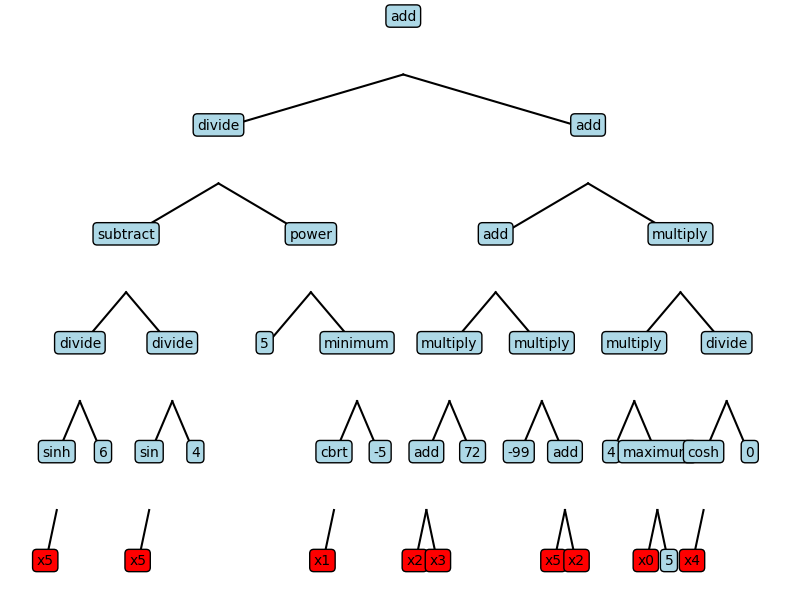

In [124]:
tree_clone = best_tree.copy_tree()
print(best_tree.to_np_formula())
Tree.collapse_branch(tree_clone.root,0,force_collapse=True)
tree_clone.compute_fitness()           
if(tree_clone.fitness is not None or tree_clone.fitness is not np.inf and tree_clone.fitness is not np.nan):
                    best_tree = tree_clone


print(f"Collapsed formula: {best_tree.to_np_formula(use_std_operators=True)}\n") #use_std_operators=True to use standard operators (+,-,*,/)
print("Tree drawing (after collapsing):")
best_tree.add_drawing()
